<a href="https://colab.research.google.com/github/Nikitaion/TensorFlowLearning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10. Milestone Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to get you familiar with working with time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin. 

## What is a time series problem?

Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.

![example time series problems](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-example-time-series-problems.png)

| Problem Type | Examples | Output |
| ----- | ----- | ----- |
| **Classification** | Anomaly detection, time series identification (where did this time series come from?) | Discrete (a label) |
| **Forecasting** | Predicting stock market prices, forecasting future demand for a product, stocking inventory requirements | Continuous (a number) |

In both cases above, a supervised learning approach is often used. Meaning, you'd have some example data and a label assosciated with that data.

For example, in forecasting the price of Bitcoin, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).

Can you guess what kind of problem BitPredict 💰📈 is?

## What we're going to cover

* Get time series data (the historical price of Bitcoin)
  * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
  * Creating training and test sets (the wrong way)
  * Creating training and test sets (the right way)
  * Visualizing time series data
  * Turning time series data into a supervised learning problem (windowing)
  * Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
  * Dense (fully-connected) networks
  * Sequence models (LSTM and 1D CNN)
  * Ensembling (combining multiple models together)
  * Multivariate models
  * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS (the turkey problem) 

In [2]:
# Check for GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get data

To build a time series forecasting model, the first thing we're going to need is data.

And since we're trying to predict the price of Bitcoin, we'll need Bitcoin data.

Specifically, we're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

Why these dates?

Because 01 October 2013 is when our data source ([Coindesk](https://www.coindesk.com/price/bitcoin)) started recording the price of Bitcoin and 18 May 2021 is when this notebook was created.

If you're going through this notebook at a later date, you'll be able to use what you learn to predict on later dates of Bitcoin, you'll just have to adjust the data source.

> 📖 **Resource:** To get the Bitcoin historical data, I went to the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin), clicked on "all" and then clicked on "Export data" and selected "CSV". 

You can find the data we're going to use on [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv).



In [3]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2022-03-05 15:11:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-03-05 15:11:00 (7.13 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas
Now we've got some data to work with, let's import it using pandas so we can visualize it.

Because our data is in **CSV (comma separated values)** format (a very common data format for time series), we'll use the pandas [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name our of the date column ("Date").

In [4]:
import pandas as pd

# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col="Date") # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [7]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

For example, collecting one sample at different time frames results in:

| 1 sample per timeframe | Number of samples per year |
| ----- | ----- |
| Second | 31,536,000 |
| Hour | 8,760 |
| Day | 365 |
| Week | 52 |
| Month | 12 |

> 🔑 **Note:** The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand behing higher in Summer months for air conditioning than Winter months). For more on different time series patterns, see [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html).

![different types of time series patterns](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-types-of-time-series-patterns.png)
*Example of different kinds of patterns you'll see in time series data. Notice the bottom right time series (Google stock price changes) has little to no patterns, making it difficult to predict. See [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html) for full graphic.*

Deep learning algorithms usually flourish with lots of data, in the range of thousands to millions of samples.

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

But that doesn't we can't try them with our data.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [8]:
pd.DataFrame(df["Closing Price (USD)"])

,Closing Price (USD)
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


In [9]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)" : "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


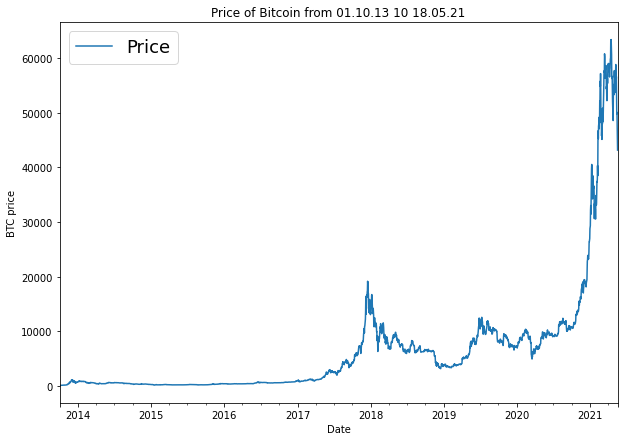

In [10]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC price")
plt.title("Price of Bitcoin from 01.10.13 10 18.05.21")
plt.legend(fontsize=18)

### Importing time series data with Python's CSV module

If your time series data comes in CSV form you don't necessarily have to use pandas.

You can use Python's [in-built `csv` module](https://docs.python.org/3/library/csv.html). And if you're working with dates, you might also want to use Python's [`datetime`](https://docs.python.org/3/library/datetime.html).

Let's see how we can replicate the plot we created before except this time using Python's `csv` and `datetime` modules.

> 📖 **Resource:** For a great guide on using Python's `csv` module, check out Real Python's tutorial on [Reading and Writing CSV files in Python](https://realpython.com/python-csv/).

In [11]:
# Importing and formatting  data
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as csv_file:
  csv_reader = csv.reader(csv_file, delimiter = ',')
  
  next(csv_reader) # use next for skipping first line in csv

  for row in csv_reader:
    timesteps.append(datetime.strptime(row[1], "%Y-%m-%d")) # strptime - make DateTime from string
    btc_price.append(float(row[2])) # get price Closing Price (USD) as float 

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

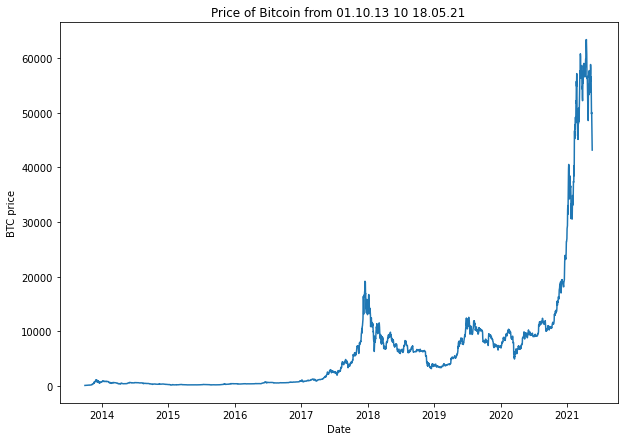

In [12]:
# plotting csv without using pandas

import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC price")
plt.title("Price of Bitcoin from 01.10.13 10 18.05.21")
plt.xlabel("Date")


## Format Data Part 1: Creatining train and test sets for time series data

Usually, you could create a train and test split using a function like Scikit-Learn's outstanding [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) but as we'll see in a moment, this doesn't really cut it for time series data.

But before we do create splits, it's worth talking about what *kind* of data we have.

In time series problems, you'll either have **univariate** or **multivariate** data.

Can you guess what our data is?

* **Univariate** time series data deals with *one* variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
* **Multivariate** time series data deals with *more than one* variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.

![comparison of univariate and multivariate time series data](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-univariate-and-multivariate-time-series-data.png)
*Example of univariate and multivariate time series data. Univariate involves using the target to predict the target. Multivariate inolves using the target as well as another time series to predict the target.*

### Create train & test sets for time series (the wrong way)

We've figured out we're dealing with a univariate time series, so we only have to make a split on one variable (for multivariate time series, you will have to split multiple variables). 

How about we first see the *wrong way* for splitting time series data?

Let's turn our DataFrame index and column into NumPy arrays.

In [13]:
# Get btc date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [14]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2229,), (558,), (2229,), (558,))

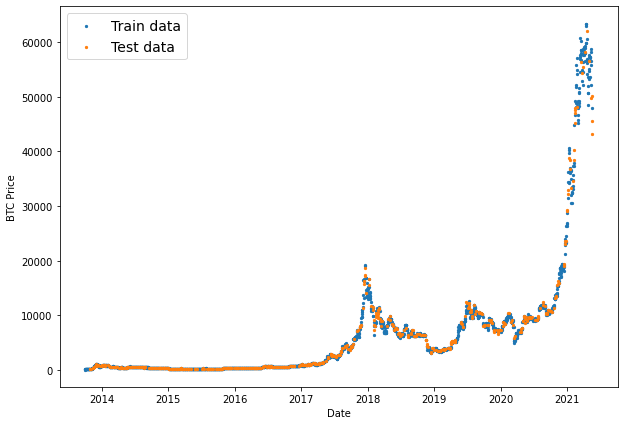

In [15]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

What's wrong with this plot?

Well, let's remind ourselves of what we're trying to do.

We're trying to use the historical price of Bitcoin to predict future prices of Bitcoin.

With this in mind, our seen data (training set) is what?

Prices of Bitcoin in the past.

And our unseen data (test set) is?

Prices of Bitcoin in the future. 

Does the plot above reflect this?

No. 

Our test data is scattered all throughout the training data.

This kind of random split is okay for datasets without a time component (such as images or passages of text for classification problems) but for time series, we've got to take the time factor into account.

To fix this, we've got to split our data in a way that reflects what we're actually trying to do.

We need to split our historical Bitcoin data to have a dataset that reflects the past (train set) and a dataset that reflects the future (test set).





### Create train & test sets for time series (the right way)

Of course, there's no way we can actually access data from the future.

But we can engineer our test set to be in the future with respect to the training set.

To do this, we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)
*Demonstration of time series split. Rather than a traditionaly random train/test split, it's best to split the time series data sequentially. Meaning, the test data should be data from the future when compared to the training data.*

In [16]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test. We can change values as we need

# Create train data splits (everithing before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

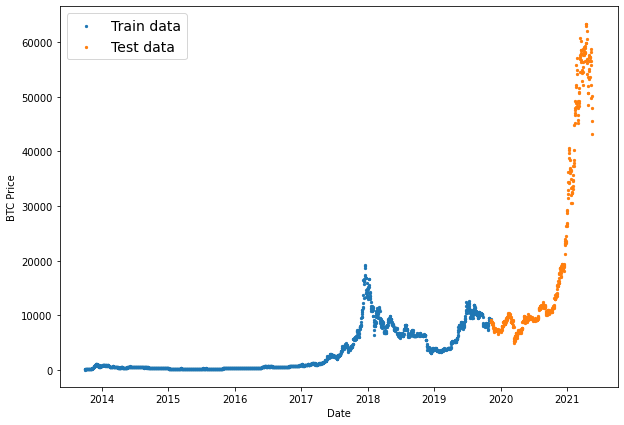

In [17]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

That looks much better!

We're going to be using the training set (past) to train a model to try and predict values on the test set (future).

Because the test set is an *artificial* future, we can gauge how our model might perform on *actual* future data.

> 🔑 **Note:** The amount of data you reserve for your test set not set in stone. You could have 80/20, 90/10, 95/5 splits or in some cases, you might not even have enough data to split into train and test sets (see the resource below). The point is to remember the test set is a pseudofuture and not the actual future, it is only meant to give you an indication of how the models you're building are performing. 

> 📖 **Resource:** Working with time series data can be tricky compared to other kinds of data. And there are a few pitfalls to watch out for, such as how much data to use for a test set. The article [*3 facts about time series forecasting that surprise experienced machine learning practitioners*](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) talks about different things to watch out for when working with time series data, I'd recommend reading it.



### Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [18]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None, ylabel="BTC Price"):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values (Default None)
  """
  # Plot time series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel(ylabel)

  if label:
    plt.legend(fontsize = 16) # make label bigger
  plt.grid(True)

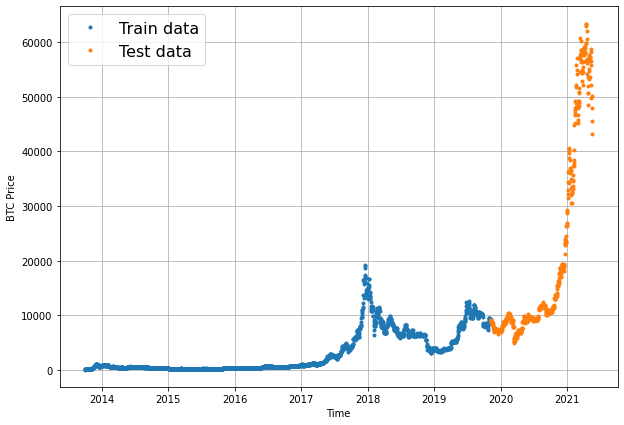

In [19]:
# Try out our plotting function
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We can build almost any kind of model for our problem as long as the data inputs and outputs are formatted correctly.

However, just because we *can* build *almost any* kind of model, doesn't mean it'll perform well/should be used in a production setting.

We'll see what this means as we build and evaluate models throughout.

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**. 
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA| 
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

> 🔑 **Note:** To reiterate, as you can see, we can build many types of models for the data we're working with. But that doesn't mean that they'll perform well. Deep learning is a powerful technique but it doesn't always work. And as always, start with a simple model first and then add complexity as needed. 

## Model 0: Naïve forecast (baseline)

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$ 

In English: 
> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).

Sound simple?

Maybe not.

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with *any* kind of model is quite hard.

> 🔑 **Note:** For the sake of this notebook, an **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a **closed system** the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [20]:
# Create a naive forecast
naive_forecast = y_test[:-1] # Naive forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10 

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

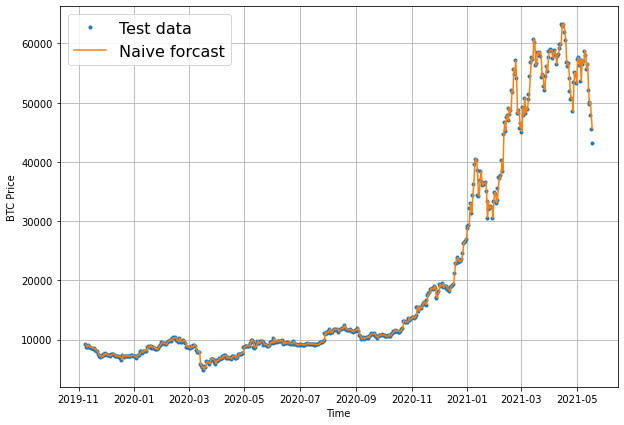

In [21]:
# Plot nave forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forcast")


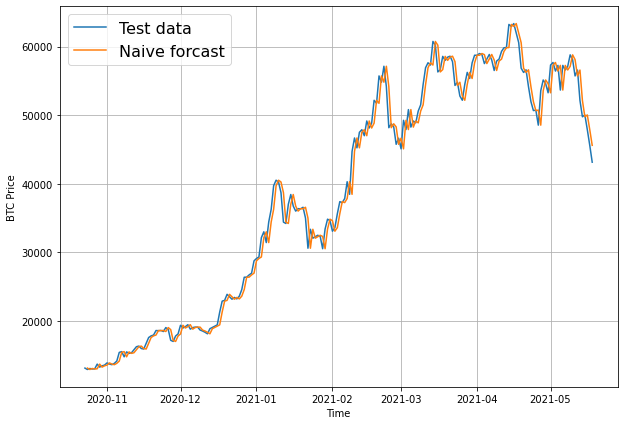

In [22]:
# Plot nave forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forcast")


## Evaluating a time series model

Time series forecasting often involves predicting a number (in our case, the price of Bitcoin).

And problem for predicting a number - regression

With this known, we can use regression evaluation metrics to evaluate our time series forecasts.

The main thing we will be evaluating is: **how do our model's predictions (`y_pred`) compare against the actual values (`y_true` or *ground truth values*)**? 

> 📖 **Resource:** We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html), I'd recommend reading through here for a more in-depth overview of what we're going to practice.

For all of the following metrics, **lower is better** (for example an MAE of 0 is better than an MAE 100).

### Scale-dependent errors

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.

| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) | 
| **sMAPE** (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

> 🤔 **Question:** There are so many metrics... which one should I pay most attention to? It's going to depend on your problem. However, since its ease of interpretation (you can explain it in a sentence to your grandma), MAE is often a very good place to start.

Since we're going to be evaluing a lot of models, let's write a function to help us calculate evaluation metrics on their forecasts.

First we'll need TensorFlow.


In [23]:
import tensorflow as tf

And since TensorFlow doesn't have a ready made version of MASE (mean aboslute scaled error), how about we create our own?

We'll take inspiration from [sktime](https://github.com/alan-turing-institute/sktime)'s (Scikit-Learn for time series) [`MeanAbsoluteScaledError`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.MeanAbsoluteScaledError.html#sktime.performance_metrics.forecasting.MeanAbsoluteScaledError) class which calculates the MASE.

In [24]:
# MASE implmentation courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))
  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [25]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

You'll notice the version of MASE above doesn't take in the training values like sktime's `mae_loss()`. In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's put each of our different evaluation metrics together into a function.

In [26]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations). Float 32 - default tf size, so float64 may call error
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [27]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}


Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [28]:
tf.reduce_mean(y_test) # Average price

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737226>

Okay, looking at these two values is starting to give us an idea of how our model is performing:
* The average price of Bitcoin in the test dataset is: $20,056 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

* Each prediction in naive forecast is on average off by: $567

Is this enough to say it's a good model?

That's up your own interpretation. Personally, I'd prefer a model which was closer to the mark.

How about we try and build one?


## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

Since we've got a naïve forecast baseline to work with, it's time we start building models to try and beat it.

And because this course is focused on TensorFlow and deep learning, we're going to be using TensorFlow to build deep learning models to try and improve on our naïve forecasting results.

That being said, there are many other kinds of models you may want to look into for building baselines/performing forecasts.

Some of them may even beat our best performing models in this notebook, however, I'll leave trying them out for extra-curriculum.

| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats | 
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

Surely we'd be ready to start building models by now?

We're so close! Only one more step (really two) to go.

We've got to window our time series.

Why do we window?

Windowing is a method to turn a time series dataset into **supervised learning problem**. 

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Or for the price of Bitcoin, it'd look like:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

![windows and horizons for turning time series data into a supervised learning problem](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-windows-and-horizons.png)
*Example of windows and horizons for Bitcoin data. Windowing can be used to turn time series data into a supervised learning problem.*

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).

In [29]:
print(f"We want to use window size of 7: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use window size of 7: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [30]:
# Setup global variables for window and horizon size
HORIZON = 1 # predict next 1 dey
WINDOW_SIZE = 7 # Use the past week of btc data to make the prediction

In [31]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [32]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8) + 1, axis = 0)) # +1 because its going to start from 0, but we need from 1
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [33]:
test_window

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [34]:
test_label

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>

In [35]:
tf.expand_dims(tf.range(8), axis = 0), tf.expand_dims(tf.range(8) +1, axis = 0)

(<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7, 8]], dtype=int32)>)

Oh yeah, that's what I'm talking about!

Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [36]:
import numpy as np

In [37]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size. .T for transposing
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  # print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [38]:
# np.arange(7+1)

In [39]:
# window_step = np.expand_dims(np.arange(7+1), axis=0)
# print(f"Window step:\n {window_step}")

In [40]:
# window_indexes = window_step + np.expand_dims(np.arange(len(prices)-(7 + 1 - 1)), axis=0).T # create 2D array of windows of size window_size
# print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

In [41]:
# tf.expand_dims(tf.range(8) + 1, axis = 0)

In [42]:
# window_step + np.expand_dims(np.arange(len(prices)-(7 + 1 - 1)), axis=0).T

In [43]:
full_windows, full_labels = make_windows(x=prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [44]:
full_windows, full_labels

(array([[  123.65499   ,   125.455     ,   108.58483   , ...,
           121.33866   ,   120.65533   ,   121.795     ],
        [  125.455     ,   108.58483   ,   118.67466   , ...,
           120.65533   ,   121.795     ,   123.033     ],
        [  108.58483   ,   118.67466   ,   121.33866   , ...,
           121.795     ,   123.033     ,   124.049     ],
        ...,
        [58788.20967893, 58102.19142623, 55715.54665129, ...,
         52147.82118698, 49764.1320816 , 50032.69313676],
        [58102.19142623, 55715.54665129, 56573.5554719 , ...,
         49764.1320816 , 50032.69313676, 47885.62525472],
        [55715.54665129, 56573.5554719 , 52147.82118698, ...,
         50032.69313676, 47885.62525472, 45604.61575361]]),
 array([[  123.033     ],
        [  124.049     ],
        [  125.96116   ],
        ...,
        [47885.62525472],
        [45604.61575361],
        [43144.47129086]]))

In [45]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [46]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑 **Note:** You can find a function which achieves similar results to the ones we implemented above at [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).

## Turning windows into training and test sets 

Time to turn our windows into training and test splits.

We could've windowed our existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.

In [47]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [48]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1 - test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [49]:
# Create train and test windos
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [50]:
len(full_windows) * 0.8

2224.0

In [51]:
print(train_windows[:5]) 
print()
print(train_labels[:5])

[[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
 [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]
 [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ]
 [118.67466 121.33866 120.65533 121.795   123.033   124.049   125.96116]
 [121.33866 120.65533 121.795   123.033   124.049   125.96116 125.27966]]

[[123.033  ]
 [124.049  ]
 [125.96116]
 [125.27966]
 [125.9275 ]]


In [52]:
print(test_windows[:5]) 
print()
print(test_labels[:5])

[[9290.89660239 9202.41545055 9369.62808116 9326.59962378 9335.75240233
  9226.48582088 8794.35864452]
 [9202.41545055 9369.62808116 9326.59962378 9335.75240233 9226.48582088
  8794.35864452 8798.04205463]
 [9369.62808116 9326.59962378 9335.75240233 9226.48582088 8794.35864452
  8798.04205463 9081.18687849]
 [9326.59962378 9335.75240233 9226.48582088 8794.35864452 8798.04205463
  9081.18687849 8711.53433917]
 [9335.75240233 9226.48582088 8794.35864452 8798.04205463 9081.18687849
  8711.53433917 8760.89271814]]

[[8798.04205463]
 [9081.18687849]
 [8711.53433917]
 [8760.89271814]
 [8749.52059102]]


In [53]:
# Check to see if train labels are the same (before and after label split) 
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:]) # array_equal - comparing 2 arrays

True

In [54]:
train_labels[:5].shape, np.squeeze(train_labels[:5]).shape

((5, 1), (5,))

## Make a modelling checkpoint callback

We're so close to building models.

Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing apples to apples.

What I mean by this is in order for a fair comparison, we want to compare each model's best performance against each model's best performance.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of our other models: compare the best against the best.

To take of this, we'll implement a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

That way when evaluating our model we could restore its best performing configuration from file.

> 🔑 **Note:** Because of the size of the dataset (smaller than usual), you'll notice our modelling experiment results fluctuate quite a bit during training (hence the implementation of the `ModelCheckpoint` callback to save the best model).

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

To do this, we'll write a small function to create a `ModelCheckpoint` callback which saves a model to specified filename.

In [55]:
import os

# Create a function to implment a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, #only output a limited amount of text
                                            save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Time to build one of our models.

If you think we've been through a fair bit of preprocessing before getting here, you're right.

Often, preparing data for a model is one of the largest parts of any machine learning project.

And once you've got a good model in place, you'll probably notice far more improvements from manipulating the data (e.g. collecting more, improving the quality) than manipulating the model.

We're going to start by keeping it simple, `model_1` will have:
* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previosly we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation. 

A batch size of 32 works pretty well too and we could always train for less epochs but since the model runs so fast (you'll see in a second, it's because the number of samples we have isn't massive) we might as well train for more.

> 🔑 **Note:** As always, many of the values for machine learning problems are experimental. A reminder that the values you can set yourself in a machine learning algorithm (the hidden units, the batch size, horizon size, window size) are called [**hyperparameters**](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning). And experimenting to find the best values for hyperparameters is called **hyperparameter tuning**. Where as parameters learned by a model itself (patterns in the data, formally called weights & biases) are referred to as **parameters**.

Let's import TensorFlow and build our first deep learning model for time series.

In [56]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it


# 2. Compile a model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"]) # we don't necessarily need this when the loss function is already MAE

# 3. Fit the model
model_1.fit(x=train_windows,# train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 3s 108ms/step - loss: 780.3469 - mae: 780.3469 - mse: 2312739.0000 - val_loss: 2279.5828 - val_mae: 2279.5828 - val_mse: 12772095.0000
Epoch 2/100
18/18 [==============================] - 1s 69ms/step - loss: 247.6765 - mae: 247.6765 - mse: 285480.9062 - val_loss: 1005.9864 - val_mae: 1005.9864 - val_mse: 3441759.2500
Epoch 3/100
18/18 [==============================] - 1s 56ms/step - loss: 188.4107 - mae: 188.4107 - mse: 171890.0312 - val_loss: 923.2859 - val_mae: 923.2859 - val_mse: 2868195.0000
Epoch 4/100
18/18 [==============================] - 1s 54ms/step - loss: 169.4334 - mae: 169.4334 - mse: 151699.4375 - val_loss: 900.5932 - val_mae: 900.5932 - val_mse: 2683713.7500
Epoch 5/100
18/18 [==============================] - 1s 54ms/step - loss: 165.0900 - mae: 165.0900 - mse: 145490.8750 - val_loss: 895.2405 - val_mae: 895.2405 - val_mse: 2564606.2500
Epoch 6/100
18/18 [==============================] - 1s 54ms/step - loss: 158.

In [57]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 662.5322 - mae: 662.5322 - mse: 1358192.1250


[662.5322265625, 662.5322265625, 1358192.125]

In [58]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

# Its better when we use best epoch from callback

18/18 [==============================] - 0s 1ms/step - loss: 568.5499 - mae: 568.5499 - mse: 1172587.7500


[568.5498657226562, 568.5498657226562, 1172587.75]

In [59]:
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Making forecasts with a model (on the test dataset)

We've trained a model and evaluated the it on the test data, but the project we're working on is called BitPredict 💰📈 so how do you think we could use our model to make predictions?

Since we're going to be running more modelling experiments, let's write a function which: 
1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on) 
3. Passes the input data to the model's `predict()` method
4. Returns the predictions



In [60]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [61]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8874.493, 8789.944, 9040.986, 8804.829, 8741.21 , 8749.835,
        8705.865, 8513.171, 8478.415, 8536.302], dtype=float32)>)

> 🔑 **Note:** With these outputs, our model isn't *forecasting* yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture.

Now we've got some prediction values, let's use the `evaluate_preds()` we created before to compare them to the ground truth.

In [62]:
# Evaluare preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)

model_1_results

{'mae': 568.5498,
 'mape': 2.549229,
 'mase': 0.99878454,
 'mse': 1172587.6,
 'rmse': 1082.8608}

In [63]:
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

It looks like our naïve model beats our first deep model on nearly every metric.

That goes to show the power of the naïve model and the reason for having a baseline for any machine learning project.

And of course, no evaluation would be finished without visualizing the results.

Let's use the `plot_time_series()` function to plot `model_1_preds` against the test data.

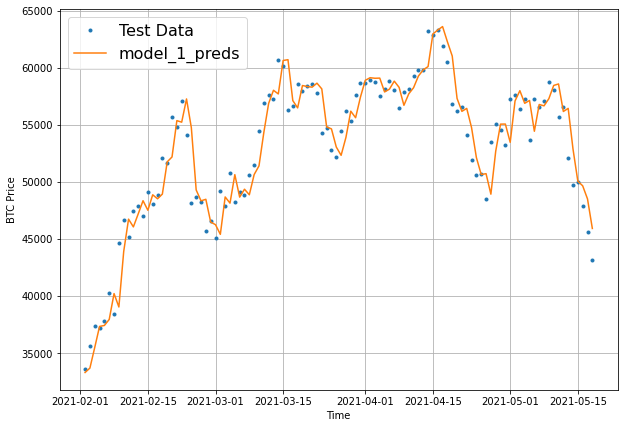

In [64]:
# Plot model_1 predictions
offset = 450
plt.figure(figsize=(10, 7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data") # [:, 0] for getting zero dimension

plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

A naïve model is currently beating our handcrafted deep learning model. 

We can't let this happen.

Let's continue our modelling experiments.

We'll keep the previous model architecture but use a window size of 30.

In other words, we'll use the previous 30 days of Bitcoin prices to try and predict the next day price.

![bitcoin prices windowed for 30 days to predict a horizon of 1 day](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-price-window-for-one-month.png)
*Example of Bitcoin prices windowed for 30 days to predict a horizon of 1.*

> 🔑 **Note:** Recall from before, the window size (how many timesteps to use to fuel a forecast) and the horizon (how many timesteps to predict into the future) are **hyperparameters**. This means you can tune them to try and find values will result in better performance.

We'll start our second modelling experiment by preparing datasets using the functions we created earlier.

###Plan:

1. Create windows
2. Split to train/test
3. Create/compile/fit model with callback
4. Making forecast
5. Visualise
6. Compare with naive model

In [65]:
HORIZON = 1
WINDOW_SIZE = 30

In [66]:
# 1. Create windows
model_2_full_windows, model_2_full_labels = make_windows(x=prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(model_2_full_windows), len(model_2_full_labels)

(2757, 2757)

In [67]:
# First 3 from full windows and full labels
for i in range(0, 3):
  print(f"Window {model_2_full_windows[i]} have a label {model_2_full_labels[i]}")

Window [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795
 123.033   124.049   125.96116 125.27966 125.9275  126.38333 135.24199
 133.20333 142.76333 137.92333 142.95166 152.55183 160.33883 164.31499
 177.63333 188.29716 200.70166 180.355   175.03166 177.6965  187.15983
 192.75666 197.4    ] have a label [196.02499]
Window [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033
 124.049   125.96116 125.27966 125.9275  126.38333 135.24199 133.20333
 142.76333 137.92333 142.95166 152.55183 160.33883 164.31499 177.63333
 188.29716 200.70166 180.355   175.03166 177.6965  187.15983 192.75666
 197.4     196.02499] have a label [198.04883]
Window [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049
 125.96116 125.27966 125.9275  126.38333 135.24199 133.20333 142.76333
 137.92333 142.95166 152.55183 160.33883 164.31499 177.63333 188.29716
 200.70166 180.355   175.03166 177.6965  187.15983 192.75666 197.4
 196.02499 198.04883] have a label [198.932

In [68]:
# 2. Make train/test splits
model_2_train_windows, model_2_test_windows, model_2_train_labels, model_2_test_labels = make_train_test_splits(model_2_full_windows, model_2_full_labels, test_split=0.2)
len(model_2_train_windows), len(model_2_test_windows), len(model_2_train_labels), len(model_2_test_labels)

(2205, 552, 2205, 552)

In [69]:
print(model_2_train_windows[:5]) 
print()
print(model_2_train_labels[:5])

[[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795
  123.033   124.049   125.96116 125.27966 125.9275  126.38333 135.24199
  133.20333 142.76333 137.92333 142.95166 152.55183 160.33883 164.31499
  177.63333 188.29716 200.70166 180.355   175.03166 177.6965  187.15983
  192.75666 197.4    ]
 [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033
  124.049   125.96116 125.27966 125.9275  126.38333 135.24199 133.20333
  142.76333 137.92333 142.95166 152.55183 160.33883 164.31499 177.63333
  188.29716 200.70166 180.355   175.03166 177.6965  187.15983 192.75666
  197.4     196.02499]
 [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049
  125.96116 125.27966 125.9275  126.38333 135.24199 133.20333 142.76333
  137.92333 142.95166 152.55183 160.33883 164.31499 177.63333 188.29716
  200.70166 180.355   175.03166 177.6965  187.15983 192.75666 197.4
  196.02499 198.04883]
 [118.67466 121.33866 120.65533 121.795   123.033   124.049   125.96116
  125

In [70]:
print(model_2_test_windows[:5]) 
print()
print(model_2_test_labels[:5])

[[8337.81899854 8162.44       8003.82039479 8058.05808111 7970.2394756
  7943.34710706 8200.3187634  8200.24609949 8073.40954388 7420.41583649
  7460.61741593 8591.22389742 9171.30653186 9578.36755607 9458.22335963
  9455.72469261 9225.99547934 9131.41063031 9197.63234462 9290.89660239
  9202.41545055 9369.62808116 9326.59962378 9335.75240233 9226.48582088
  8794.35864452 8798.04205463 9081.18687849 8711.53433917 8760.89271814]
 [8162.44       8003.82039479 8058.05808111 7970.2394756  7943.34710706
  8200.3187634  8200.24609949 8073.40954388 7420.41583649 7460.61741593
  8591.22389742 9171.30653186 9578.36755607 9458.22335963 9455.72469261
  9225.99547934 9131.41063031 9197.63234462 9290.89660239 9202.41545055
  9369.62808116 9326.59962378 9335.75240233 9226.48582088 8794.35864452
  8798.04205463 9081.18687849 8711.53433917 8760.89271814 8749.52059102]
 [8003.82039479 8058.05808111 7970.2394756  7943.34710706 8200.3187634
  8200.24609949 8073.40954388 7420.41583649 7460.61741593 8591.2

In [71]:
# Create/compile/fit model with callback

tf.random.set_seed(42)

# Create a model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_2_dense")

# Compile a model
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"],
                loss="mae")

# Fit a model
model_2.fit(x=model_2_train_windows,
            y=model_2_train_labels,
            validation_data=(model_2_test_windows, model_2_test_labels),
            batch_size=128,
            verbose=0,
            epochs=100,
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [72]:
# Making forecast

In [73]:
model_2.evaluate(model_2_test_windows, model_2_test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 658.0289 - mae: 658.0289 - mse: 1417080.8750


[658.0288696289062, 658.0288696289062, 1417080.875]

In [74]:
# Load in saved best performing model_1 and evaluate it on test data
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense")
model_2.evaluate(model_2_test_windows, model_2_test_labels)

# Its better when we use best epoch from callback

18/18 [==============================] - 0s 3ms/step - loss: 608.8480 - mae: 608.8480 - mse: 1284314.3750


[608.8480224609375, 608.8480224609375, 1284314.375]

In [75]:
model_2_preds = make_preds(model_2, model_2_test_windows)
len(model_2_preds), model_2_preds[:5]

(552,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([8903.553, 8932.773, 8792.956, 8590.411, 8454.575], dtype=float32)>)

In [76]:
# Evaluare preds
model_2_results = evaluate_preds(y_true=tf.squeeze(model_2_test_labels), # reduce to right shape/delete an extra dimension
                                 y_pred=model_2_preds)

model_2_results

{'mae': 608.84814,
 'mape': 2.7680664,
 'mase': 1.0642724,
 'mse': 1284314.4,
 'rmse': 1133.276}

In [77]:
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

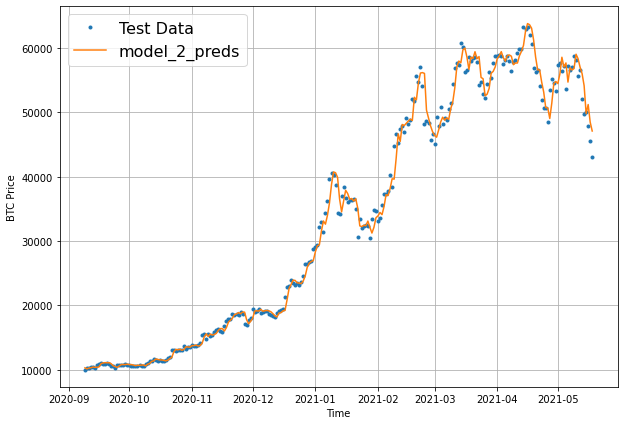

In [78]:
# Plot model_2 predictions
offset = 300
plt.figure(figsize=(10, 7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(model_2_test_windows):], values=model_2_test_labels[:, 0], start=offset, label="Test Data")

plot_time_series(timesteps=X_test[-len(model_2_test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.


In [79]:
HORIZON = 7
WINDOW_SIZE = 30

model_3_full_windows, model_3_full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(model_3_full_windows), len(model_3_full_labels)

(2751, 2751)

In [80]:
model_3_train_windows, model_3_test_windows, model_3_train_labels, model_3_test_labels = make_train_test_splits(windows=model_3_full_windows, labels=model_3_full_labels, test_split=0.2)
len(model_3_train_windows), len(model_3_test_windows), len(model_3_train_labels), len(model_3_test_labels)

(2200, 551, 2200, 551)

In [81]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name = "model_3_dense")

# Compile
model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(model_3_train_windows,
            model_3_train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(model_3_test_windows, model_3_test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [82]:
# Evaluate
model_3.evaluate(model_3_test_windows, model_3_test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1322.7781


1322.778076171875

In [83]:
# Load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(model_3_test_windows, model_3_test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1228.1417


1228.1417236328125

In [84]:
# Make predictions with model_3. The predictions are going to be 7 steps at a time (this is the HORIZON size)

model_3_preds = make_preds(model_3,
                           input_data=model_3_test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9233.328 , 9332.702 , 9363.651 , 9442.775 , 9401.978 , 9414.001 ,
        9280.01  ],
       [8911.084 , 9065.984 , 9113.08  , 9026.601 , 8990.093 , 9000.148 ,
        9053.433 ],
       [8848.506 , 9018.2295, 9006.146 , 8934.578 , 8929.888 , 8856.351 ,
        8958.367 ],
       [9048.449 , 9058.819 , 8966.749 , 9127.248 , 8982.123 , 9056.629 ,
        9002.575 ],
       [8958.309 , 9008.146 , 8827.891 , 8995.736 , 9129.433 , 9099.142 ,
        8881.021 ]], dtype=float32)>

In [85]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(model_3_test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  559.42004 ,   276.0053  ,   298.20258 ,   408.06152 ,
          431.32047 ,   526.28064 ,   542.41644 ,   459.79108 ,
          490.63736 ,   631.6582  ,   802.51654 ,   731.79333 ,
          684.06476 ,   789.71857 ,   563.4593  ,   271.9013  ,
          231.86858 ,   258.64767 ,   277.65277 ,   291.5478  ,
          105.425575,   132.63156 ,   205.97643 ,   262.20816 ,
          169.8651  ,   165.05127 ,   110.21959 ,    83.64655 ,
          115.86182 ,   152.87025 ,   279.98862 ,   380.96127 ,
          280.21414 ,   271.9101  ,   264.43088 ,   261.91315 ,
          330.29108 ,   242.21861 ,   253.72746 ,   245.38596 ,
          412.562   ,   128.63539 ,    88.56452 ,    92.15639 ,
          100.39704 ,   102.41455 ,    74.52804 ,    94.00349 ,
           84.86837 ,    76.64781 ,   108.49679 ,   144.869   ,
          187.69133 ,   162.5261  ,   265.83133 ,   391.21323 ,
          552.2943  ,   541.77313 ,   522.20886 ,   523.98157 ,
          430.13052 ,   276.80893

In [86]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([551, 7]), TensorShape([552]))

## Make our evaluation function work for larger horizons

You'll notice the outputs for `model_3_results` are multi-dimensional. 

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [87]:
model_3_results["mae"].shape, model_2_results["mae"].shape, model_3_results["mae"].ndim, model_2_results["mae"].ndim

((551,), (), 1, 0)

In [88]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations). Float 32 - default tf size, so float64 may call error
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [89]:
model_3_results = evaluate_preds(y_true=tf.squeeze(model_3_test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1228.1416,
 'mape': 5.4698334,
 'mase': 2.1854093,
 'mse': 5323686.5,
 'rmse': 1412.9114}

In [90]:
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

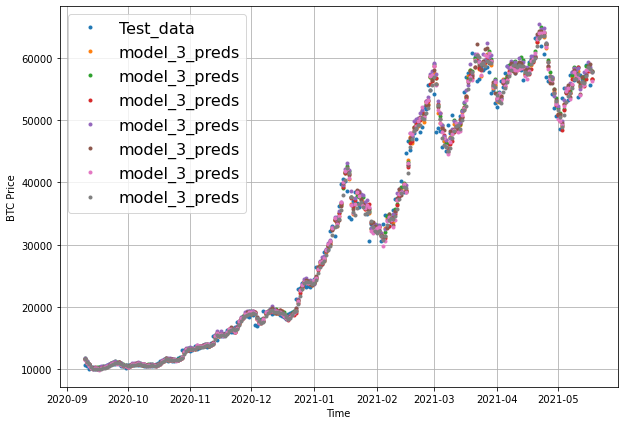

In [91]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(model_3_test_windows):], values=model_3_test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(model_3_test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

When we try to plot our multi-horizon predicts, we get a funky looking plot.

Again, we can fix this by aggregating our model's predictions.

> 🔑 **Note:** Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7-days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days.

In [92]:
model_3_preds[0], tf.reduce_mean(model_3_preds[0])

(<tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([9233.328, 9332.702, 9363.651, 9442.775, 9401.978, 9414.001,
        9280.01 ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=9352.635>)

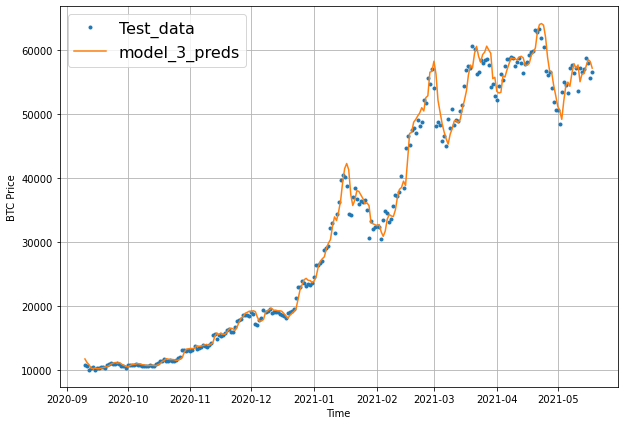

In [93]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(model_3_test_windows):], values=model_3_test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(model_3_test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), # use mean value
                 start=offset, 
                 format="-",
                 label="model_3_preds")

## Which of our models is performing best so far?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.

In [94]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index = ["mae"])

,naive,horizon_1_window_7,horizon_1_window_30,horizon_7_window_30
mae,567.980225,568.549805,608.848145,1228.141602


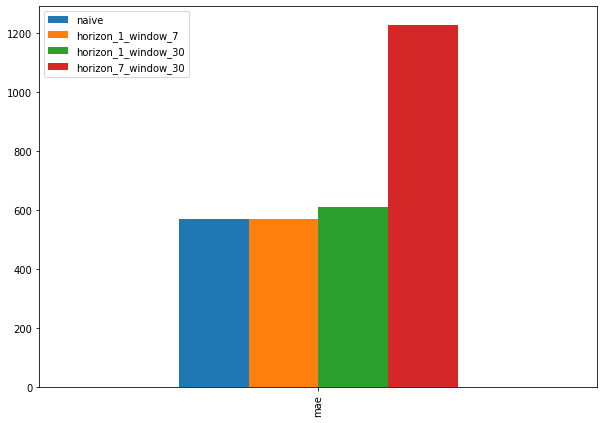

In [95]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index = ["mae"]).plot(figsize=(10,7), kind="bar")

Woah, our naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of **autocorrelation** in the data. If a time series has **autocorrelation** it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.

> 📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [*How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls*](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) by Vegard Flovik

## Model 4: Conv1D

Onto the next modelling experiment!

This time, we'll be using a Conv1D model. Because as we saw in the sequence modelling notebook, Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

![bitcoin prediction in seq2seq terms](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-forecast-in-seq2seq-terms.png)
*Framing Bitcoin forecasting in seq2seq (sequence to sequence) terms. Using a window size of 7 and a horizon of one results in a many to one problem. Using a window size of >1 and a horizon of >1 results in a many to many problem. The diagram comes from Andrei Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*.

Before we build a Conv1D model, let's recreate our datasets.

In [96]:
HORIZON = 1
WINDOW_SIZE = 7

In [97]:
# Create windowed data
model_4_full_windows, model_4_full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(model_4_full_windows), len(model_4_full_labels)

(2780, 2780)

In [98]:
# Create train/test sets
model_4_train_windows, model_4_test_windows, model_4_train_labels, model_4_test_labels = make_train_test_splits(windows=model_4_full_windows, labels=model_4_full_labels, test_split=0.2)
len(model_4_train_windows), len(model_4_test_windows), len(model_4_train_labels), len(model_4_test_labels)

(2224, 556, 2224, 556)

Now, since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the `batch_size` (by default this is 32 but we can change it) is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin 
* `input_dim = HORIZON` - our model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension. 

In [99]:
# Check data sample shapes
model_4_train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a [`tf.keras.layers.Lamdba`](https://keras.io/api/layers/core_layers/lambda/) (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

Let's try it out.

In [100]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(model_4_train_windows[0])
x, model_4_train_windows[0]

(<tf.Tensor: shape=(7,), dtype=float64, numpy=
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ])>,
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ]))

In [101]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps (input_dim)
expand_dims_layer

In [102]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


Now we've got a Lambda layer, let's build, compile, fit and evaluate a Conv1D model on our data.

> 🔑 **Note:** If you run the model below without the Lambda layer, you'll get an input shape error (one of the most common errors when building neural networks).

In [103]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),  # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"), # kernel_size - size of sliding window
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(model_4_train_windows,
            model_4_train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(model_4_test_windows, model_4_test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets wr

In [104]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_8 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [105]:
model_2.summary() # Output shape different

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               3968      
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [106]:
# Evaluate model
model_4.evaluate(model_4_test_windows, model_4_test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 624.1893


624.1892700195312

In [107]:
# Load back in best performing Conv1D and re-evaluate
model_4 = tf.keras.models.load_model("/content/model_experiments/model_4_conv1D")
model_4.evaluate(model_4_test_windows, model_4_test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 569.0326


569.0325927734375

In [108]:
# Make predictions
model_4_preds = make_preds(model_4, model_4_test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8847.293, 8757.503, 8997.469, 8762.801, 8707.722, 8713.594,
       8664.935, 8496.83 , 8439.473, 8499.395], dtype=float32)>

In [109]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(model_4_test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.03265,
 'mape': 2.5515256,
 'mase': 0.9996328,
 'mse': 1169841.0,
 'rmse': 1081.5919}

In [110]:
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Model 5: RNN (LSTM)

As you might've guessed, we can also use a recurrent neural network to model our sequential time series data.

> 📖 **Resource:** For more on the different types of recurrent neural networks you can use for sequence problems, see the [Recurrent Neural Networks section of notebook 08](https://dev.mrdbourke.com/tensorflow-deep-learning/08_introduction_to_nlp_in_tensorflow/#recurrent-neural-networks-rnns).

Let's reuse the same data we used for the Conv1D model, except this time we'll create an [LSTM-cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) powered RNN to model our Bitcoin data. 

Once again, one of the most important steps for the LSTM model will be getting our data into the right shape.

The [`tf.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer takes a tensor with `[batch, timesteps, feature]` dimensions.

As mentioned earlier, the `batch` dimension gets taken care of for us but our data is currently only has the `feature` dimension (`WINDOW_SIZE`).

To fix this, just like we did with the `Conv1D` model, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer.

In [111]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))

x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)  # expand input dimension to be compatible with LSTM
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss activation function results in a massive error
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(model_4_train_windows, # use data same as model 4
            model_4_train_labels, # use data same as model 4
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(model_4_test_windows, model_4_test_labels), # use data same as model 4
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 2544.2009 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 127ms/step - loss: 2323.6123 - val_loss: 9224.3506
Epoch 2/100
12/18 [===================>..........] - ETA: 0s - loss: 905.3286 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 695.4956 - val_loss: 1485.8942
Epoch 3/100
14/18 [======================>.......] - ETA: 0s - loss: 250.9574INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 237.3010 - val_loss: 1298.9436
Epoch 4/100
13/18 [====================>.........] - ETA: 0s - loss: 189.4993INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 181.9182 - val_loss: 966.6407
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 173.4021 - val_loss: 970.9384
Epoch 6/100
10/18 [===============>..............] - ETA: 0s - loss: 169.4054INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 123ms/step - loss: 172.3319 - val_loss: 891.5209
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 168.9708 - val_loss: 968.6377
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 169.5318 - val_loss: 963.4456
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 167.5760 - val_loss: 956.5829
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 166.3443 - val_loss: 936.8956
Epoch 11/100
18/18 [==============================] - 0s 6ms/step - loss: 165.4762 - val_loss: 909.1110
Epoch 12/100
12/18 [===================>..........] - ETA: 0s - loss: 170.8306INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 103ms/step - loss: 169.9951 - val_loss: 891.2327
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 160.3806 - val_loss: 898.5595
Epoch 14/100
18/18 [==============================] - 0s 6ms/step - loss: 157.6484 - val_loss: 927.9266
Epoch 15/100
18/18 [==============================] - 0s 6ms/step - loss: 167.6508 - val_loss: 982.9256
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 160.4521 - val_loss: 916.0458
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 153.8805 - val_loss: 928.6927
Epoch 18/100
12/18 [===================>..........] - ETA: 0s - loss: 160.4999INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 103ms/step - loss: 152.1556 - val_loss: 865.6219
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 148.8319 - val_loss: 876.9328
Epoch 20/100
14/18 [======================>.......] - ETA: 0s - loss: 153.0263INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 149.6801 - val_loss: 831.2376
Epoch 21/100
12/18 [===================>..........] - ETA: 0s - loss: 148.3610INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 126ms/step - loss: 145.7330 - val_loss: 821.0629
Epoch 22/100
18/18 [==============================] - 0s 6ms/step - loss: 143.9433 - val_loss: 821.2911
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 143.1268 - val_loss: 837.1895
Epoch 24/100
13/18 [====================>.........] - ETA: 0s - loss: 139.7682INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 100ms/step - loss: 141.0378 - val_loss: 808.0547
Epoch 25/100
13/18 [====================>.........] - ETA: 0s - loss: 142.0081INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 99ms/step - loss: 139.0068 - val_loss: 787.0112
Epoch 26/100
13/18 [====================>.........] - ETA: 0s - loss: 135.4655INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 126ms/step - loss: 137.9395 - val_loss: 769.2203
Epoch 27/100
18/18 [==============================] - 0s 6ms/step - loss: 136.4498 - val_loss: 772.5977
Epoch 28/100
12/18 [===================>..........] - ETA: 0s - loss: 134.8586INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 112ms/step - loss: 135.2745 - val_loss: 751.0115
Epoch 29/100
18/18 [==============================] - 0s 7ms/step - loss: 135.5958 - val_loss: 759.8718
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 138.2377 - val_loss: 789.2983
Epoch 31/100
12/18 [===================>..........] - ETA: 0s - loss: 135.2388INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 108ms/step - loss: 133.4514 - val_loss: 730.3293
Epoch 32/100
18/18 [==============================] - 0s 6ms/step - loss: 129.2459 - val_loss: 730.9674
Epoch 33/100
12/18 [===================>..........] - ETA: 0s - loss: 130.9456INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 128.6682 - val_loss: 726.6902
Epoch 34/100
12/18 [===================>..........] - ETA: 0s - loss: 134.7901INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 125ms/step - loss: 128.9641 - val_loss: 708.2340
Epoch 35/100
13/18 [====================>.........] - ETA: 0s - loss: 130.3760INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 107ms/step - loss: 126.4375 - val_loss: 702.6016
Epoch 36/100
12/18 [===================>..........] - ETA: 0s - loss: 124.1017INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 125.8648 - val_loss: 696.0234
Epoch 37/100
12/18 [===================>..........] - ETA: 0s - loss: 121.2189INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 122ms/step - loss: 124.2744 - val_loss: 692.3998
Epoch 38/100
12/18 [===================>..........] - ETA: 0s - loss: 126.5789INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 123.4617 - val_loss: 682.3129
Epoch 39/100
18/18 [==============================] - 0s 6ms/step - loss: 124.4908 - val_loss: 689.1117
Epoch 40/100
18/18 [==============================] - 0s 6ms/step - loss: 123.6601 - val_loss: 688.7414
Epoch 41/100
13/18 [====================>.........] - ETA: 0s - loss: 126.6606INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 99ms/step - loss: 121.6996 - val_loss: 673.3080
Epoch 42/100
13/18 [====================>.........] - ETA: 0s - loss: 120.4197INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 98ms/step - loss: 121.2662 - val_loss: 665.5682
Epoch 43/100
12/18 [===================>..........] - ETA: 0s - loss: 117.1598INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 127ms/step - loss: 121.1914 - val_loss: 663.4371
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 121.3492 - val_loss: 666.4625
Epoch 45/100
13/18 [====================>.........] - ETA: 0s - loss: 117.6605INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 119.4222 - val_loss: 653.1441
Epoch 46/100
13/18 [====================>.........] - ETA: 0s - loss: 122.5126INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 99ms/step - loss: 119.1475 - val_loss: 649.3669
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 119.5113 - val_loss: 650.3450
Epoch 48/100
14/18 [======================>.......] - ETA: 0s - loss: 116.5278INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 103ms/step - loss: 117.9849 - val_loss: 643.7015
Epoch 49/100
18/18 [==============================] - 0s 7ms/step - loss: 117.3458 - val_loss: 649.1431
Epoch 50/100
18/18 [==============================] - 0s 6ms/step - loss: 119.0112 - val_loss: 658.5665
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 118.3833 - val_loss: 673.2418
Epoch 52/100
18/18 [==============================] - 0s 7ms/step - loss: 118.0016 - val_loss: 644.5724
Epoch 53/100
14/18 [======================>.......] - ETA: 0s - loss: 117.6709INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 126ms/step - loss: 117.5012 - val_loss: 632.1457
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 117.3330 - val_loss: 637.2055
Epoch 55/100
13/18 [====================>.........] - ETA: 0s - loss: 122.7085INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 100ms/step - loss: 115.8615 - val_loss: 627.7058
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 117.1814 - val_loss: 648.4813
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 125.8361 - val_loss: 648.9831
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 115.4787 - val_loss: 630.3375
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 114.6559 - val_loss: 628.4244
Epoch 60/100
12/18 [===================>..........] - ETA: 0s - loss: 113.9881INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 100ms/step - loss: 114.8021 - val_loss: 620.0607
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 114.3845 - val_loss: 633.4195
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 114.7735 - val_loss: 653.0529
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 118.5447 - val_loss: 622.3017
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 113.3439 - val_loss: 646.4648
Epoch 65/100
18/18 [==============================] - 0s 6ms/step - loss: 115.5774 - val_loss: 621.8207
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 113.5758 - val_loss: 625.8535
Epoch 67/100
 9/18 [==============>...............] - ETA: 0s - loss: 110.7601INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 119ms/step - loss: 114.3274 - val_loss: 618.1777
Epoch 68/100
12/18 [===================>..........] - ETA: 0s - loss: 115.4240INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 115.8874 - val_loss: 610.0667
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 118.1946 - val_loss: 630.6259
Epoch 70/100
18/18 [==============================] - 0s 7ms/step - loss: 117.6780 - val_loss: 613.6976
Epoch 71/100
18/18 [==============================] - 0s 8ms/step - loss: 112.6891 - val_loss: 628.7469
Epoch 72/100
18/18 [==============================] - 0s 7ms/step - loss: 115.3159 - val_loss: 613.3113
Epoch 73/100
12/18 [===================>..........] - ETA: 0s - loss: 112.2831INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 108ms/step - loss: 112.2513 - val_loss: 607.5436
Epoch 74/100
18/18 [==============================] - 0s 6ms/step - loss: 113.5405 - val_loss: 612.9193
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 114.6243 - val_loss: 680.9974
Epoch 76/100
18/18 [==============================] - 0s 7ms/step - loss: 114.3978 - val_loss: 627.7791
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 115.0701 - val_loss: 677.3135
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 115.6408 - val_loss: 638.9863
Epoch 79/100
13/18 [====================>.........] - ETA: 0s - loss: 110.3607INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 106ms/step - loss: 113.8102 - val_loss: 603.6312
Epoch 80/100
18/18 [==============================] - 0s 6ms/step - loss: 111.6164 - val_loss: 621.9382
Epoch 81/100
18/18 [==============================] - 0s 6ms/step - loss: 111.7110 - val_loss: 620.0795
Epoch 82/100
10/18 [===============>..............] - ETA: 0s - loss: 122.9477INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 128ms/step - loss: 114.4341 - val_loss: 598.3356
Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 112.8585 - val_loss: 607.5803
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 111.8406 - val_loss: 602.6411
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 111.2613 - val_loss: 627.6544
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 113.9645 - val_loss: 619.5224
Epoch 87/100
11/18 [=================>............] - ETA: 0s - loss: 118.5497INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 110ms/step - loss: 113.8286 - val_loss: 598.2933
Epoch 88/100
12/18 [===================>..........] - ETA: 0s - loss: 114.0405INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 110.8448 - val_loss: 596.0640
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 111.0922 - val_loss: 630.6047
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 115.8214 - val_loss: 680.3810
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 116.0425 - val_loss: 632.1270
Epoch 92/100
13/18 [====================>.........] - ETA: 0s - loss: 111.5993INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 103ms/step - loss: 111.9858 - val_loss: 596.0399
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 111.9554 - val_loss: 601.6699
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 110.7805 - val_loss: 605.7480
Epoch 95/100
13/18 [====================>.........] - ETA: 0s - loss: 110.0177INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 125ms/step - loss: 110.1889 - val_loss: 594.1672
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 112.3372 - val_loss: 601.4485
Epoch 97/100
18/18 [==============================] - 0s 6ms/step - loss: 110.8521 - val_loss: 625.3636
Epoch 98/100
11/18 [=================>............] - ETA: 0s - loss: 112.1291INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 103ms/step - loss: 110.8161 - val_loss: 594.1018
Epoch 99/100
14/18 [======================>.......] - ETA: 0s - loss: 106.8749INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 140ms/step - loss: 109.7159 - val_loss: 591.6655
Epoch 100/100
18/18 [==============================] - 0s 11ms/step - loss: 112.6171 - val_loss: 594.9865


In [112]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(model_4_test_windows, model_4_test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 591.6655


591.6654663085938

In [113]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, model_4_test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8970.957, 8815.352, 9026.793, 8831.478, 8736.686, 8804.464,
       8733.207, 8540.421, 8518.281, 8544.508], dtype=float32)>

In [114]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(model_4_test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 591.6655,
 'mape': 2.66558,
 'mase': 1.0393925,
 'mse': 1250831.5,
 'rmse': 1118.4058}

Hmmm... it seems even with an LSTM-powered RNN we weren't able to beat our naïve models results.

Perhaps adding another variable will help?

> 🔑 **Note:** I'm putting this here again as a reminder that because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.


## Make a multivariate time series 

So far all of our models have barely kept up with the naïve forecast.

And so far all of them have been trained on a single variable (also called univariate time series): the historical price of Bitcoin.

If predicting the price of Bitcoin using the price of Bitcoin hasn't worked out very well, maybe giving our model more information may help.

More information is a vague term because we could actually feed almost anything to our model(s) and they would still try to find patterns. 

For example, we could use the historical price of Bitcoin as well as anyone with the name Elon Musk Tweeted on that day to predict the future price of Bitcoin.

But would this help?

Porbably not.

What would be better is if we passed our model something related to Bitcoin (again, this is quite vauge, since in an open system like a market, you could argue everything is related).

This will be different for almost every time series you work on but in our case, we could try to see if the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) adds any predictive power to our model(s).

What is the Bitcoin block reward size?

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.

Let's encode this information into our time series data and see if it helps a model's performance.

> 🔑 **Note:** Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from **univariate** (only the historical price of Bitcoin) to **multivariate** (the price of Bitcoin as well as the block reward size).

In [115]:
bitcoin_prices.head

<bound method NDFrame.head of                    Price
Date                    
2013-10-01    123.654990
2013-10-02    125.455000
2013-10-03    108.584830
2013-10-04    118.674660
2013-10-05    121.338660
...                  ...
2021-05-14  49764.132082
2021-05-15  50032.693137
2021-05-16  47885.625255
2021-05-17  45604.615754
2021-05-18  43144.471291

[2787 rows x 1 columns]>

Alright, time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) | 

> 🔑 **Note:** Since our Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

In [116]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

We're going to get the days (indexes) for different block reward values. 

This is important because if we're going to use multiple variables for our time series, they have to the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

> 🔑 **Note:** For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model.

In [117]:
# Now we can add another feature to our dataset block_reward (this gets lower over time so it may lead to increasing prices of Bitcoin).

# Add block_reward column
block_reward_2_days = (block_reward_3_datetime -  bitcoin_prices.index[0]).days # index[0] - starting date of our dataset
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [118]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy() # copy dataframe
bitcoin_prices_block["block_reward"] = None # add column to our new dataframe

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2 # -1 - block reward column
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


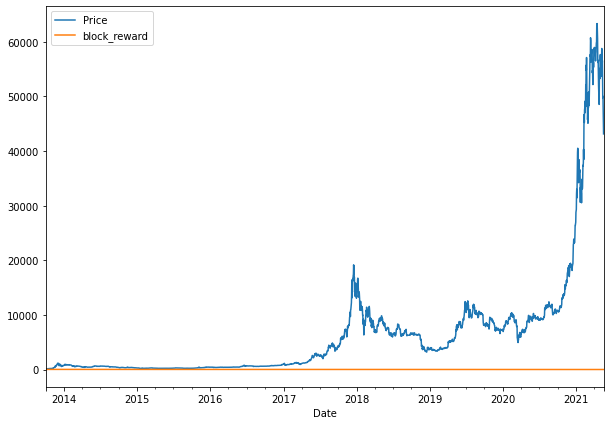

In [119]:
bitcoin_prices_block.plot(figsize=(10,7))

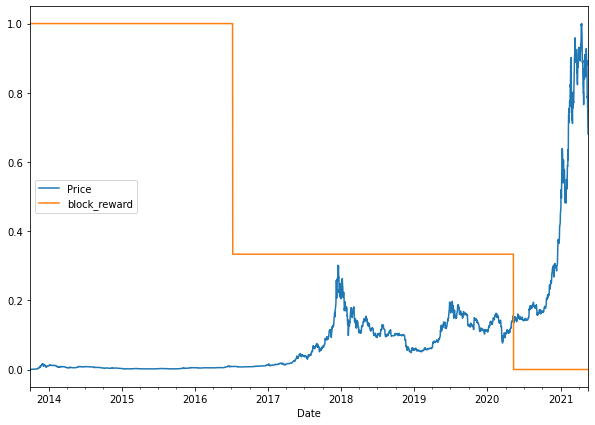

In [120]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7))

When we scale the block reward and the Bitcoin price, we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.

## Making a windowed dataset with pandas

Previously, we used some custom made functions to window our **univariate** time series.

However, since we've just added another variable to our dataset, these functions won't work.

Not to worry though. Since our data is in a pandas DataFrame, we can leverage the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.

Let's see it in action.

In [121]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [122]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


Now that we've got a windowed dataset, let's separate features (`X`) from labels (`y`).

Remember in our windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

```
Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

We'll also remove the `NaN` values using pandas [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method, this equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

In [123]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [124]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [125]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

To keep things simple, let's the `model_1` architecture and use it to train and make predictions on our multivariate time series data.

By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [126]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivriate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 5s - loss: 2853.4023INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 1s 31ms/step - loss: 1234.6881 - val_loss: 2061.8193
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 337.6970INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 26ms/step - loss: 351.5003 - val_loss: 1908.7338
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 249.1817INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 27ms/step - loss: 235.4110 - val_loss: 1329.5337
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 271.0568INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 26ms/step - loss: 208.6456 - val_loss: 1102.0098
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 196.5595 - val_loss: 1108.6184
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 145.3714INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 187.2317 - val_loss: 1035.9945
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 231.4434INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 26ms/step - loss: 182.0119 - val_loss: 1019.2759
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 151.5187INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 24ms/step - loss: 175.6998 - val_loss: 977.7363
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 142.1548INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 170.1651 - val_loss: 953.9060
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 177.7931INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 164.3849 - val_loss: 912.1844
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 171.4948INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 24ms/step - loss: 158.0432 - val_loss: 871.2962
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 146.7134INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 26ms/step - loss: 151.8589 - val_loss: 853.0031
Epoch 13/100
18/18 [==============================] - 0s 3ms/step - loss: 150.1562 - val_loss: 899.1051
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 153.5457INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 26ms/step - loss: 147.8199 - val_loss: 845.0215
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 147.3238INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 26ms/step - loss: 142.5173 - val_loss: 788.1895
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 125.2893INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 137.1697 - val_loss: 770.6407
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 124.4618INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 136.0208 - val_loss: 763.1685
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 144.2260INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 135.4696 - val_loss: 753.5220
Epoch 19/100
18/18 [==============================] - 0s 3ms/step - loss: 130.7954 - val_loss: 758.8011
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 145.1222INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 128.6773 - val_loss: 703.7007
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 163.2315INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 26ms/step - loss: 129.2461 - val_loss: 693.4253
Epoch 22/100
18/18 [==============================] - 0s 3ms/step - loss: 125.8202 - val_loss: 703.4459
Epoch 23/100
18/18 [==============================] - 0s 3ms/step - loss: 127.8713 - val_loss: 698.5746
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 134.4187INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 1s 42ms/step - loss: 122.4124 - val_loss: 672.5025
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 133.0910INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 121.3311 - val_loss: 666.3878
Epoch 26/100
18/18 [==============================] - 0s 3ms/step - loss: 127.9873 - val_loss: 693.5912
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 181.3063INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 26ms/step - loss: 124.8371 - val_loss: 645.3120
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 111.9599INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 119.8579 - val_loss: 641.3580
Epoch 29/100
18/18 [==============================] - 0s 4ms/step - loss: 121.2880 - val_loss: 665.6819
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 131.9141INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 24ms/step - loss: 121.1822 - val_loss: 640.8665
Epoch 31/100
18/18 [==============================] - 0s 3ms/step - loss: 120.4115 - val_loss: 667.9382
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 119.8528INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 26ms/step - loss: 118.3126 - val_loss: 618.9246
Epoch 33/100
18/18 [==============================] - 0s 3ms/step - loss: 115.8836 - val_loss: 621.7656
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 131.4358INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 26ms/step - loss: 114.9744 - val_loss: 611.1629
Epoch 35/100
18/18 [==============================] - 0s 3ms/step - loss: 112.5883 - val_loss: 615.9460
Epoch 36/100
18/18 [==============================] - 0s 3ms/step - loss: 115.2489 - val_loss: 616.3090
Epoch 37/100
18/18 [==============================] - 0s 3ms/step - loss: 114.1561 - val_loss: 612.4226
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 108.7143INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 26ms/step - loss: 111.4725 - val_loss: 602.2158
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 127.2392INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 113.2853 - val_loss: 597.4957
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 100.3340INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 27ms/step - loss: 109.8442 - val_loss: 594.1268
Epoch 41/100
18/18 [==============================] - 0s 4ms/step - loss: 110.6678 - val_loss: 618.8137
Epoch 42/100
18/18 [==============================] - 0s 4ms/step - loss: 115.6730 - val_loss: 597.8903
Epoch 43/100
18/18 [==============================] - 0s 3ms/step - loss: 110.8469 - val_loss: 598.7615
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 64.0537INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 27ms/step - loss: 109.6574 - val_loss: 589.3683
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 108.7725 - val_loss: 611.4686
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 87.0587INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 109.6011 - val_loss: 587.5862
Epoch 47/100
18/18 [==============================] - 0s 3ms/step - loss: 110.3633 - val_loss: 634.5792
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3613 - val_loss: 641.6946
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 166.8425INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 26ms/step - loss: 112.7560 - val_loss: 581.5458
Epoch 50/100
18/18 [==============================] - 0s 3ms/step - loss: 108.7167 - val_loss: 645.5017
Epoch 51/100
18/18 [==============================] - 0s 3ms/step - loss: 110.1508 - val_loss: 601.1295
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 111.2310 - val_loss: 604.3268
Epoch 53/100
18/18 [==============================] - 0s 3ms/step - loss: 111.7207 - val_loss: 637.5751
Epoch 54/100
18/18 [==============================] - 0s 3ms/step - loss: 113.4848 - val_loss: 598.4417
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 129.2513INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 109.9909 - val_loss: 575.7916
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 108.7174 - val_loss: 778.8638
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 124.3417 - val_loss: 684.9166
Epoch 58/100
18/18 [==============================] - 0s 3ms/step - loss: 113.7253 - val_loss: 578.1144
Epoch 59/100
18/18 [==============================] - 0s 3ms/step - loss: 106.6669 - val_loss: 587.5107
Epoch 60/100
18/18 [==============================] - 0s 3ms/step - loss: 107.3718 - val_loss: 604.5578
Epoch 61/100
18/18 [==============================] - 0s 3ms/step - loss: 107.3551 - val_loss: 579.4937
Epoch 62/100
18/18 [==============================] - 0s 4ms/step - loss: 107.1465 - val_loss: 590.5042
Epoch 63/100
18/18 [==============================] - 0s 3ms/step - loss: 110.3243 - val_loss: 656.7155
Epoch 64/100
18/18 [==============================] - 0s 4ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 24ms/step - loss: 112.8277 - val_loss: 571.7220
Epoch 66/100
18/18 [==============================] - 0s 3ms/step - loss: 111.0755 - val_loss: 586.5446
Epoch 67/100
18/18 [==============================] - 0s 3ms/step - loss: 106.8978 - val_loss: 605.0892
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 112.7144 - val_loss: 721.4490
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 125.0426 - val_loss: 675.2729
Epoch 70/100
18/18 [==============================] - 0s 3ms/step - loss: 120.6351 - val_loss: 583.3210
Epoch 71/100
18/18 [==============================] - 0s 3ms/step - loss: 110.7660 - val_loss: 617.2184
Epoch 72/100
18/18 [==============================] - 0s 4ms/step - loss: 107.5005 - val_loss: 573.3959
Epoch 73/100
18/18 [==============================] - 0s 3ms/step - loss: 109.0864 - val_loss: 598.6373
Epoch 74/100
18/18 [==============================] - 0s 3ms/step - loss: 10

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 26ms/step - loss: 106.8613 - val_loss: 569.7409
Epoch 78/100
 1/18 [>.............................] - ETA: 0s - loss: 105.1003INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 106.2962 - val_loss: 569.5549
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 105.4122 - val_loss: 587.1082
Epoch 80/100
18/18 [==============================] - 0s 3ms/step - loss: 106.3550 - val_loss: 575.5302
Epoch 81/100
18/18 [==============================] - 0s 4ms/step - loss: 105.4703 - val_loss: 573.0568
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 189.4042INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 111.8128 - val_loss: 569.2524
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 110.6720 - val_loss: 643.0097
Epoch 84/100
18/18 [==============================] - 0s 3ms/step - loss: 110.1933 - val_loss: 578.6867
Epoch 85/100
18/18 [==============================] - 0s 3ms/step - loss: 105.9973 - val_loss: 580.7704
Epoch 86/100
18/18 [==============================] - 0s 3ms/step - loss: 106.2998 - val_loss: 574.9788
Epoch 87/100
18/18 [==============================] - 0s 3ms/step - loss: 104.6251 - val_loss: 579.1246
Epoch 88/100
18/18 [==============================] - 0s 3ms/step - loss: 105.5787 - val_loss: 578.4384
Epoch 89/100
 1/18 [>.............................] - ETA: 0s - loss: 106.7115INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 24ms/step - loss: 106.2337 - val_loss: 568.6239
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 104.4805 - val_loss: 603.5804
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 107.7674 - val_loss: 609.6353
Epoch 92/100
18/18 [==============================] - 0s 3ms/step - loss: 107.0758 - val_loss: 578.5643
Epoch 93/100
18/18 [==============================] - 0s 3ms/step - loss: 113.8534 - val_loss: 660.6248
Epoch 94/100
18/18 [==============================] - 0s 3ms/step - loss: 110.9860 - val_loss: 569.0593
Epoch 95/100
18/18 [==============================] - 0s 4ms/step - loss: 106.0804 - val_loss: 591.7425
Epoch 96/100
18/18 [==============================] - 0s 3ms/step - loss: 114.2290 - val_loss: 611.8524
Epoch 97/100
18/18 [==============================] - 0s 3ms/step - loss: 107.7527 - val_loss: 584.7697
Epoch 98/100
18/18 [==============================] - 0s 3ms/step - loss: 10

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


18/18 [==============================] - 0s 25ms/step - loss: 108.0866 - val_loss: 568.3356
Epoch 100/100
18/18 [==============================] - 0s 3ms/step - loss: 108.8599 - val_loss: 645.7151


Multivariate model fit!

You might've noticed that the model inferred the input shape of our data automatically (the data now has an extra feature). Often this will be the case, however, if you're running into shape issues, you can always explicitly define the input shape using `input_shape` parameter of the first layer in a model.

Time to evaluate our multivariate model.

In [127]:
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 645.7151


645.715087890625

In [128]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivriate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 568.3355


568.3355102539062

In [129]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8845.381 , 8769.115 , 9044.852 , 8745.515 , 8727.0625, 8773.182 ,
       8669.289 , 8502.578 , 8469.248 , 8527.997 ], dtype=float32)>

In [130]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 568.33545,
 'mape': 2.5493133,
 'mase': 0.99840796,
 'mse': 1164860.0,
 'rmse': 1079.2867}

In [131]:
model_1_results

{'mae': 568.5498,
 'mape': 2.549229,
 'mase': 0.99878454,
 'mse': 1172587.6,
 'rmse': 1082.8608}

In [132]:
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

It looks like the adding in the block reward may have helped our model slightly.

But there a few more things we could try.

> 📖 **Resource:** For different ideas on how to improve a neural network model (from a model perspective), refer to the [*Improving a model*](https://dev.mrdbourke.com/tensorflow-deep-learning/02_neural_network_classification_in_tensorflow/#improving-a-model) section in notebook 02.


> 🛠 **Exercise(s):** 
> 1. Try adding an extra `tf.keras.layers.Dense()` layer with 128 hidden units to `model_6`, how does this effect model performance?
> 2. Is there a better way to create this model? As in, should the `block_reward` feature be bundled in with the Bitcoin historical price feature? Perhaps you could test whether building a multi-input model (e.g. one model input for Bitcoin price history and one model input for `block_reward`)  works better? See [*Model 4: Hybrid embedding*](https://dev.mrdbourke.com/tensorflow-deep-learning/09_SkimLit_nlp_milestone_project_2/#model-4-combining-pretrained-token-embeddings-character-embeddings-hybrid-embedding-layer) section of notebook 09 for an idea on how to create a multi-input model.

In [133]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_6_dense_multivriate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=250,
            batch_size=256,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/250
1/9 [==>...........................] - ETA: 2s - loss: 2901.2065INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 139ms/step - loss: 1196.0681 - val_loss: 3385.5918
Epoch 2/250
1/9 [==>...........................] - ETA: 0s - loss: 487.0056INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 78ms/step - loss: 334.7630 - val_loss: 1205.6072
Epoch 3/250
9/9 [==============================] - 0s 6ms/step - loss: 196.7208 - val_loss: 1385.2954
Epoch 4/250
1/9 [==>...........................] - ETA: 0s - loss: 287.8686INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 80ms/step - loss: 177.1643 - val_loss: 845.8533
Epoch 5/250
1/9 [==>...........................] - ETA: 0s - loss: 187.5589INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 78ms/step - loss: 151.7902 - val_loss: 807.4402
Epoch 6/250
1/9 [==>...........................] - ETA: 0s - loss: 120.2511INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 77ms/step - loss: 138.4092 - val_loss: 752.3264
Epoch 7/250
1/9 [==>...........................] - ETA: 0s - loss: 148.2413INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 78ms/step - loss: 132.8008 - val_loss: 717.2562
Epoch 8/250
1/9 [==>...........................] - ETA: 0s - loss: 109.5868INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 81ms/step - loss: 127.0336 - val_loss: 693.0987
Epoch 9/250
9/9 [==============================] - 0s 6ms/step - loss: 127.2779 - val_loss: 735.3857
Epoch 10/250
1/9 [==>...........................] - ETA: 0s - loss: 116.0243INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 80ms/step - loss: 127.0112 - val_loss: 677.6358
Epoch 11/250
1/9 [==>...........................] - ETA: 0s - loss: 126.1284INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 76ms/step - loss: 122.5549 - val_loss: 663.9466
Epoch 12/250
9/9 [==============================] - 0s 7ms/step - loss: 120.6391 - val_loss: 697.3770
Epoch 13/250
1/9 [==>...........................] - ETA: 0s - loss: 124.2717INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 76ms/step - loss: 121.3104 - val_loss: 643.4026
Epoch 14/250
1/9 [==>...........................] - ETA: 0s - loss: 109.2206INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 117ms/step - loss: 117.8829 - val_loss: 633.8932
Epoch 15/250
9/9 [==============================] - 0s 7ms/step - loss: 117.3078 - val_loss: 636.8187
Epoch 16/250
9/9 [==============================] - 0s 6ms/step - loss: 114.2251 - val_loss: 670.4339
Epoch 17/250
9/9 [==============================] - 0s 6ms/step - loss: 113.9111 - val_loss: 639.5479
Epoch 18/250
1/9 [==>...........................] - ETA: 0s - loss: 135.0286INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 82ms/step - loss: 113.2109 - val_loss: 610.2898
Epoch 19/250
9/9 [==============================] - 0s 6ms/step - loss: 112.9669 - val_loss: 704.4345
Epoch 20/250
1/9 [==>...........................] - ETA: 0s - loss: 133.3300INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 79ms/step - loss: 115.6441 - val_loss: 609.2704
Epoch 21/250
9/9 [==============================] - 0s 7ms/step - loss: 114.6390 - val_loss: 613.5877
Epoch 22/250
9/9 [==============================] - 0s 6ms/step - loss: 115.8364 - val_loss: 727.6556
Epoch 23/250
1/9 [==>...........................] - ETA: 0s - loss: 115.1545INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 82ms/step - loss: 121.1878 - val_loss: 607.2838
Epoch 24/250
1/9 [==>...........................] - ETA: 0s - loss: 135.4613INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 82ms/step - loss: 113.3544 - val_loss: 606.1926
Epoch 25/250
1/9 [==>...........................] - ETA: 0s - loss: 104.4950INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 79ms/step - loss: 109.7079 - val_loss: 590.9718
Epoch 26/250
9/9 [==============================] - 0s 6ms/step - loss: 107.2307 - val_loss: 599.7780
Epoch 27/250
9/9 [==============================] - 0s 6ms/step - loss: 107.8590 - val_loss: 689.8600
Epoch 28/250
9/9 [==============================] - 0s 6ms/step - loss: 116.1328 - val_loss: 591.4627
Epoch 29/250
9/9 [==============================] - 0s 6ms/step - loss: 114.2982 - val_loss: 614.8754
Epoch 30/250
9/9 [==============================] - 0s 6ms/step - loss: 121.4797 - val_loss: 717.4174
Epoch 31/250
9/9 [==============================] - 0s 7ms/step - loss: 122.9911 - val_loss: 622.1496
Epoch 32/250
9/9 [==============================] - 0s 6ms/step - loss: 117.4203 - val_loss: 691.0768
Epoch 33/250
9/9 [==============================] - 0s 6ms/step - loss: 116.0588 - val_loss: 599.5154
Epoch 34/250
1/9 [==>...........................] - ETA: 0s - loss: 113.3273INFO:tensorflow:As

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 78ms/step - loss: 107.0067 - val_loss: 589.7981
Epoch 35/250
1/9 [==>...........................] - ETA: 0s - loss: 95.9852INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 77ms/step - loss: 106.4392 - val_loss: 585.1756
Epoch 36/250
9/9 [==============================] - 0s 6ms/step - loss: 113.8648 - val_loss: 806.8722
Epoch 37/250
9/9 [==============================] - 0s 6ms/step - loss: 129.6153 - val_loss: 714.0717
Epoch 38/250
9/9 [==============================] - 0s 6ms/step - loss: 114.7383 - val_loss: 589.5422
Epoch 39/250
1/9 [==>...........................] - ETA: 0s - loss: 112.6866INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 76ms/step - loss: 108.6589 - val_loss: 584.3629
Epoch 40/250
9/9 [==============================] - 0s 6ms/step - loss: 107.1009 - val_loss: 591.5278
Epoch 41/250
9/9 [==============================] - 0s 6ms/step - loss: 109.1286 - val_loss: 592.4647
Epoch 42/250
9/9 [==============================] - 0s 6ms/step - loss: 108.1500 - val_loss: 587.8676
Epoch 43/250
1/9 [==>...........................] - ETA: 0s - loss: 112.3270INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 78ms/step - loss: 108.9361 - val_loss: 580.9451
Epoch 44/250
9/9 [==============================] - 0s 6ms/step - loss: 120.7445 - val_loss: 745.0769
Epoch 45/250
9/9 [==============================] - 0s 6ms/step - loss: 132.9676 - val_loss: 840.4147
Epoch 46/250
9/9 [==============================] - 0s 6ms/step - loss: 143.7495 - val_loss: 602.1678
Epoch 47/250
9/9 [==============================] - 0s 6ms/step - loss: 118.5505 - val_loss: 588.8328
Epoch 48/250
9/9 [==============================] - 0s 6ms/step - loss: 107.1316 - val_loss: 620.9249
Epoch 49/250
9/9 [==============================] - 0s 6ms/step - loss: 107.1395 - val_loss: 582.1487
Epoch 50/250
9/9 [==============================] - 0s 5ms/step - loss: 105.3736 - val_loss: 584.6674
Epoch 51/250
9/9 [==============================] - 0s 5ms/step - loss: 107.6035 - val_loss: 617.6285
Epoch 52/250
9/9 [==============================] - 0s 5ms/step - loss: 107.1946 - val_loss: 6

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 79ms/step - loss: 112.5559 - val_loss: 578.9061
Epoch 57/250
9/9 [==============================] - 0s 6ms/step - loss: 110.0792 - val_loss: 614.6982
Epoch 58/250
9/9 [==============================] - 0s 6ms/step - loss: 107.9897 - val_loss: 647.7554
Epoch 59/250
9/9 [==============================] - 0s 6ms/step - loss: 108.2474 - val_loss: 673.3446
Epoch 60/250
9/9 [==============================] - 0s 8ms/step - loss: 118.3037 - val_loss: 813.5530
Epoch 61/250
9/9 [==============================] - 0s 9ms/step - loss: 119.2350 - val_loss: 585.1426
Epoch 62/250
9/9 [==============================] - 0s 7ms/step - loss: 109.1866 - val_loss: 709.7583
Epoch 63/250
9/9 [==============================] - 0s 6ms/step - loss: 110.5161 - val_loss: 579.1293
Epoch 64/250
9/9 [==============================] - 0s 6ms/step - loss: 103.9267 - val_loss: 604.8580
Epoch 65/250
9/9 [==============================] - 0s 6ms/step - loss: 109.6465 - val_loss: 5

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 75ms/step - loss: 107.6304 - val_loss: 575.7408
Epoch 82/250
9/9 [==============================] - 0s 6ms/step - loss: 106.0779 - val_loss: 596.5049
Epoch 83/250
9/9 [==============================] - 0s 6ms/step - loss: 105.7178 - val_loss: 652.8334
Epoch 84/250
9/9 [==============================] - 0s 6ms/step - loss: 109.9531 - val_loss: 659.1294
Epoch 85/250
9/9 [==============================] - 0s 6ms/step - loss: 113.2073 - val_loss: 577.2504
Epoch 86/250
9/9 [==============================] - 0s 6ms/step - loss: 108.9995 - val_loss: 577.6630
Epoch 87/250
9/9 [==============================] - 0s 6ms/step - loss: 107.3823 - val_loss: 579.5548
Epoch 88/250
9/9 [==============================] - 0s 6ms/step - loss: 103.6436 - val_loss: 576.7775
Epoch 89/250
9/9 [==============================] - 0s 6ms/step - loss: 103.5647 - val_loss: 607.0978
Epoch 90/250
9/9 [==============================] - 0s 6ms/step - loss: 109.8872 - val_loss: 7

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 77ms/step - loss: 107.3552 - val_loss: 575.6604
Epoch 94/250
9/9 [==============================] - 0s 6ms/step - loss: 103.9197 - val_loss: 581.3087
Epoch 95/250
9/9 [==============================] - 0s 6ms/step - loss: 103.5483 - val_loss: 576.9154
Epoch 96/250
9/9 [==============================] - 0s 6ms/step - loss: 104.1772 - val_loss: 578.4785
Epoch 97/250
9/9 [==============================] - 0s 6ms/step - loss: 103.2021 - val_loss: 591.8086
Epoch 98/250
9/9 [==============================] - 0s 7ms/step - loss: 110.0606 - val_loss: 673.3406
Epoch 99/250
9/9 [==============================] - 0s 7ms/step - loss: 108.9675 - val_loss: 578.2502
Epoch 100/250
9/9 [==============================] - 0s 6ms/step - loss: 105.7488 - val_loss: 576.1680
Epoch 101/250
1/9 [==>...........................] - ETA: 0s - loss: 93.8026INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 73ms/step - loss: 106.4689 - val_loss: 575.4422
Epoch 102/250
9/9 [==============================] - 0s 9ms/step - loss: 103.9662 - val_loss: 585.4016
Epoch 103/250
9/9 [==============================] - 0s 6ms/step - loss: 105.2229 - val_loss: 723.3157
Epoch 104/250
1/9 [==>...........................] - ETA: 0s - loss: 126.5905INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 126ms/step - loss: 112.3808 - val_loss: 573.0498
Epoch 105/250
9/9 [==============================] - 0s 9ms/step - loss: 111.9521 - val_loss: 704.1405
Epoch 106/250
9/9 [==============================] - 0s 7ms/step - loss: 115.5682 - val_loss: 643.4579
Epoch 107/250
9/9 [==============================] - 0s 7ms/step - loss: 110.2817 - val_loss: 579.9525
Epoch 108/250
9/9 [==============================] - 0s 6ms/step - loss: 107.8629 - val_loss: 614.5643
Epoch 109/250
9/9 [==============================] - 0s 6ms/step - loss: 107.2448 - val_loss: 575.6291
Epoch 110/250
9/9 [==============================] - 0s 6ms/step - loss: 105.5150 - val_loss: 596.2357
Epoch 111/250
9/9 [==============================] - 0s 6ms/step - loss: 106.2018 - val_loss: 578.7825
Epoch 112/250
9/9 [==============================] - 0s 7ms/step - loss: 109.8178 - val_loss: 581.9759
Epoch 113/250
9/9 [==============================] - 0s 6ms/step - loss: 104.3751 - v

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 75ms/step - loss: 104.4392 - val_loss: 572.6453
Epoch 145/250
9/9 [==============================] - 0s 5ms/step - loss: 104.4994 - val_loss: 606.6849
Epoch 146/250
1/9 [==>...........................] - ETA: 0s - loss: 104.5337INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 79ms/step - loss: 105.4802 - val_loss: 572.1191
Epoch 147/250
9/9 [==============================] - 0s 6ms/step - loss: 104.6855 - val_loss: 607.1145
Epoch 148/250
9/9 [==============================] - 0s 7ms/step - loss: 113.3395 - val_loss: 642.5948
Epoch 149/250
1/9 [==>...........................] - ETA: 0s - loss: 99.4525INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 78ms/step - loss: 110.2257 - val_loss: 571.6879
Epoch 150/250
9/9 [==============================] - 0s 6ms/step - loss: 105.1808 - val_loss: 574.6393
Epoch 151/250
9/9 [==============================] - 0s 6ms/step - loss: 106.0457 - val_loss: 631.7271
Epoch 152/250
9/9 [==============================] - 0s 6ms/step - loss: 105.3209 - val_loss: 587.2360
Epoch 153/250
9/9 [==============================] - 0s 6ms/step - loss: 103.7847 - val_loss: 573.6705
Epoch 154/250
9/9 [==============================] - 0s 6ms/step - loss: 105.2499 - val_loss: 600.4323
Epoch 155/250
9/9 [==============================] - 0s 6ms/step - loss: 112.6680 - val_loss: 658.7902
Epoch 156/250
9/9 [==============================] - 0s 7ms/step - loss: 117.2112 - val_loss: 752.4279
Epoch 157/250
9/9 [==============================] - 0s 8ms/step - loss: 112.5348 - val_loss: 590.0368
Epoch 158/250
9/9 [==============================] - 0s 6ms/step - loss: 103.4752 - va

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 78ms/step - loss: 105.2842 - val_loss: 571.2094
Epoch 168/250
9/9 [==============================] - 0s 6ms/step - loss: 104.5644 - val_loss: 594.0120
Epoch 169/250
9/9 [==============================] - 0s 6ms/step - loss: 104.0146 - val_loss: 607.4883
Epoch 170/250
9/9 [==============================] - 0s 6ms/step - loss: 105.2399 - val_loss: 714.9119
Epoch 171/250
9/9 [==============================] - 0s 6ms/step - loss: 113.7053 - val_loss: 638.2098
Epoch 172/250
9/9 [==============================] - 0s 12ms/step - loss: 105.9766 - val_loss: 591.7891
Epoch 173/250
9/9 [==============================] - 0s 6ms/step - loss: 106.2952 - val_loss: 572.3789
Epoch 174/250
9/9 [==============================] - 0s 6ms/step - loss: 103.6326 - val_loss: 605.6614
Epoch 175/250
9/9 [==============================] - 0s 6ms/step - loss: 105.0943 - val_loss: 576.5060
Epoch 176/250
9/9 [==============================] - 0s 6ms/step - loss: 107.5152 - v

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivriate/assets


9/9 [==============================] - 1s 83ms/step - loss: 114.2454 - val_loss: 568.9178
Epoch 198/250
9/9 [==============================] - 0s 8ms/step - loss: 104.0344 - val_loss: 570.5614
Epoch 199/250
9/9 [==============================] - 0s 6ms/step - loss: 103.0102 - val_loss: 571.3307
Epoch 200/250
9/9 [==============================] - 0s 6ms/step - loss: 102.8529 - val_loss: 573.2136
Epoch 201/250
9/9 [==============================] - 0s 6ms/step - loss: 108.5121 - val_loss: 652.4694
Epoch 202/250
9/9 [==============================] - 0s 6ms/step - loss: 108.5349 - val_loss: 626.7039
Epoch 203/250
9/9 [==============================] - 0s 6ms/step - loss: 105.6602 - val_loss: 623.0533
Epoch 204/250
9/9 [==============================] - 0s 7ms/step - loss: 105.2437 - val_loss: 569.3090
Epoch 205/250
9/9 [==============================] - 0s 6ms/step - loss: 102.4650 - val_loss: 575.3774
Epoch 206/250
9/9 [==============================] - 0s 6ms/step - loss: 104.0941 - va

In [134]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivriate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 568.9177


568.917724609375

In [135]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8818.805, 8782.874, 9066.859, 8738.146, 8727.195, 8744.41 ,
       8676.42 , 8506.254, 8455.383, 8538.663], dtype=float32)>

In [136]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 568.9178,
 'mape': 2.56118,
 'mase': 0.99943095,
 'mse': 1164099.6,
 'rmse': 1078.9344}

## Model 7: N-BEATS algorithm

Time to step things up a notch.

So far we've tried a bunch of smaller models, models with only a couple of layers.

But one of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) (a forecasting competition).

For our next modelling experiment we're going to be replicating the **generic architecture** of the N-BEATS algorithm (see [section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).

We're not going to go through all of the details in the paper, instead we're going to focus on:
1. Replicating the model architecture in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) 

![figure 1 from N-BBEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)
*N-BEATS algorithm we're going to replicate with TensorFlow with window (input) and horizon (output) annotations.*

2. Using the same hyperparameters as the paper which can be found in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

Doing this will give us an opportunity to practice:
* Creating a custom layer for the `NBeatsBlock` by subclassing [`tf.keras.layers.Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)
  * Creating a custom layer is helpful for when TensorFlow doesn't already have an existing implementation of a layer or if you'd like to make a layer configuration repeat a number of times (e.g. like a stack of N-BEATS blocks)
* Implementing a custom architecture using the Functional API 
* Finding a paper related to our problem and seeing how it goes 

> 🔑 **Note:** As you'll see in the paper, the authors state “N-BEATS is implemented and trained in TensorFlow”, that's what we'll be doing too!


### Building and testing an N-BEATS block layer

Let's start by building an N-BEATS block layer, we'll write the code first and then discuss what's going on.

Because the N-BEATS block layer doesn't exist in TensorFlow, we're got to create it

To create custom layers and models in TensorFlow we can use subclassing:
https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [137]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int, # number of hidden neurons
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs) # super(). - Invoking the parent class (tf.keras.layers.Layer) function (__init__)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation (Figure 1 from paper)
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs
    for layer in self.hidden:
      x = layer(x) # pass inputs through each hidden layer 
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Setting up the `NBeatsBlock` custom layer we see: 
* The class inherits from `tf.keras.layers.Layer` (this gives it all of the methods assosciated with `tf.keras.layers.Layer`)
* The constructor (`def __init__(...)`) takes all of the layer hyperparameters as well as the `**kwargs` argument
  * The `**kwargs` argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, `input_shape`, `trainable` and `name`
* In the constructor, the block architecture layers are created:
  * The hidden layers are created as a stack of fully connected with `n_nuerons` hidden units layers with ReLU activation
  * The theta layer uses `theta_size` hidden units as well as linear activation
* The `call()` method is what is run when the layer is called:
  * It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)
  * After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: `input_size`) and forecast (forward predictions, shape: `horizon`) are returned

![code mapping to image of N-BEATS basic block](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-basic-block-replication-with-tensorflow-layer-subclassing.png)
*Using TensorFlow layer subclassing to replicate the N-BEATS basic block. See section 3.1 of N-BEATS paper for details.*

Let's see our block replica in action by together by creating a toy version of `NBeatsBlock`.

> 📖  **Resource:** Much of the creation of the time series materials (the ones you're going through now), including replicating the N-BEATS algorithm were streamed live on Twitch. If you'd like to see replays of how the algorithm was replicated, check out the [*Time series research and TensorFlow course material creation playlist*](https://youtube.com/playlist?list=PL8IpyNZ21vUSCM7nRAuS-hW_E-sgwdmaI) on the Daniel Bourke arXiv YouTube channel.

In [138]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE + HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4 )

In [139]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirement (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [140]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.6194284   1.0257323   0.61559236 -0.9059789   0.04036285  0.11223514
  0.37029368]
Forecast: 0.5364296436309814


### Preparing data for the N-BEATS algorithm using `tf.data`

We've got the basic building block for the N-BEATS architecture ready to go.

But before we use it to replicate the entire N-BEATS generic architecture, let's create some data.

This time, because we're going to be using a larger model architecture, to ensure our model training runs as fast as possible, we'll setup our datasets using the `tf.data` API.

And because the N-BEATS algorithm is focused on univariate time series, we'll start by making training and test windowed datasets of Bitcoin prices (just as we've done above).


In [141]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [142]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [143]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)

bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [144]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [145]:
X_train.head()

,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,
2013-10-08,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


Train and test sets ready to go!

Now let's convert them into TensorFlow `tf.data.Dataset`'s to ensure they run as fast as possible whilst training.

We'll do this by:
1. Turning the arrays in tensor Datasets using [`tf.data.Dataset.from_tensor_slices()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
  * Note: `from_tensor_slices()` works best when your data fits in memory, for extremely large datasets, you'll want to look into using the [`TFRecord` format](https://www.tensorflow.org/tutorials/load_data/tfrecord)
2. Combine the labels and features tensors into a Dataset using [`tf.data.Dataset.zip()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
3. Batch and prefetch the Datasets using [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)
  * Batching and prefetching ensures the loading time from CPU (preparing data) to GPU (computing on data) is as small as possible 

> 📖 **Resource:** For more on building highly performant TensorFlow data pipelines, I'd recommend reading through the [*Better performance with the tf.data API*](https://www.tensorflow.org/guide/data_performance) guide.

In [146]:
# Time to make dataset performant using tf.data API

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features and labels by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

Data prepared! Notice the input shape for the features `(None, 7)`, the `None` leaves space for the batch size where as the `7` represents the `WINDOW_SIZE`.

Time to get create the N-BEATS architecture. 

### Setting up hyperparameters for N-BEATS algorithm

To begin, we'll create variables for each of the hyperparameters we'll be using for our N-BEATS replica.

> 📖 **Resource:** The following hyperparameters are taken from Figure 1 and Table 18/Appendix D of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

![table 18 from N-BEATS paper](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-table-18-hyperparameters.png)
*Table 18 from [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) describing the hyperparameters used for the different variants of N-BEATS. We're using N-BEATS-G which stands for the generic version of N-BEATS.*

> 🔑 **Note:** If you see variables in a machine learning example in all caps, such as "`N_EPOCHS = 100`", these variables are often hyperparameters which are used through the example. You'll usually see them instantiated towards the start of an experiment and then used throughout.



In [147]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # HORIZON called "H" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Beautiful! Hyperparameters ready, now before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS **double residual stacking** (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:
* [`tf.keras.layers.subtract(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract) - subtracts list of input tensors from each other
* [`tf.keras.layers.add(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/add) - adds list of input tensors to each other

Let's try them out.

https://paperswithcode.com/method/resnet

In [148]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


Both of these layer functions are straight-forward, subtract or add together their inputs.

And as mentioned before, they're what powers N-BEATS double residual stacking.

The power of **residual stacking** or **residual connections** was revealed in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular [ResNet architecture](https://en.wikipedia.org/wiki/Residual_neural_network)) than previous attempts. 

This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of residual connections have been present in deep learning ever since.

> What is a residual connection?

A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:
* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack 

![N-BEATS architecture double residual stacking](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-architecture-double-residual-stacking.png)
*Annotated version of Figure 1 from the N-BEATS paper highlighting the double residual stacking (section 3.2) of the architecture. Backcast residuals of each block are subtracted from each other and used as the input to the next block where as the forecasts of each block are added together to become the stack forecast.*

> What are the benefits of residual connections?

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).  

It's thought that they help avoid the problem of [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) (patterns learned by a neural network not being passed through to deeper layers).

### Building, compiling and fitting the N-BEATS algorithm 

Okay, we've finally got all of the pieces of the puzzle ready for building and training the N-BEATS algorithm.

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for loooongggggg period of time without improvement)
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)


In [149]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock") # name from **kwargs

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 


# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 245: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 345: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1h 3min 58s, sys: 1min 40s, total: 1h 5min 38s
Wall time: 46min 30s


In [150]:
print(1)

1


In [151]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 405ms/step - loss: 583.5568 - mae: 583.5568 - mse: 1190792.7500


[583.5568237304688, 583.5568237304688, 1190792.75]

In [152]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8923.408, 8865.176, 9061.943, 8877.682, 8846.668, 8809.324,
       8689.195, 8625.805, 8541.708, 8575.579], dtype=float32)>

In [153]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 583.5568,
 'mape': 2.69948,
 'mase': 1.0251477,
 'mse': 1190792.8,
 'rmse': 1091.2345}

Even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created

You know what would be cool?

If we could plot the N-BEATS model we've crafted.

Well it turns out we can using [`tensorflow.keras.utils.plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

Let's see what it looks like.

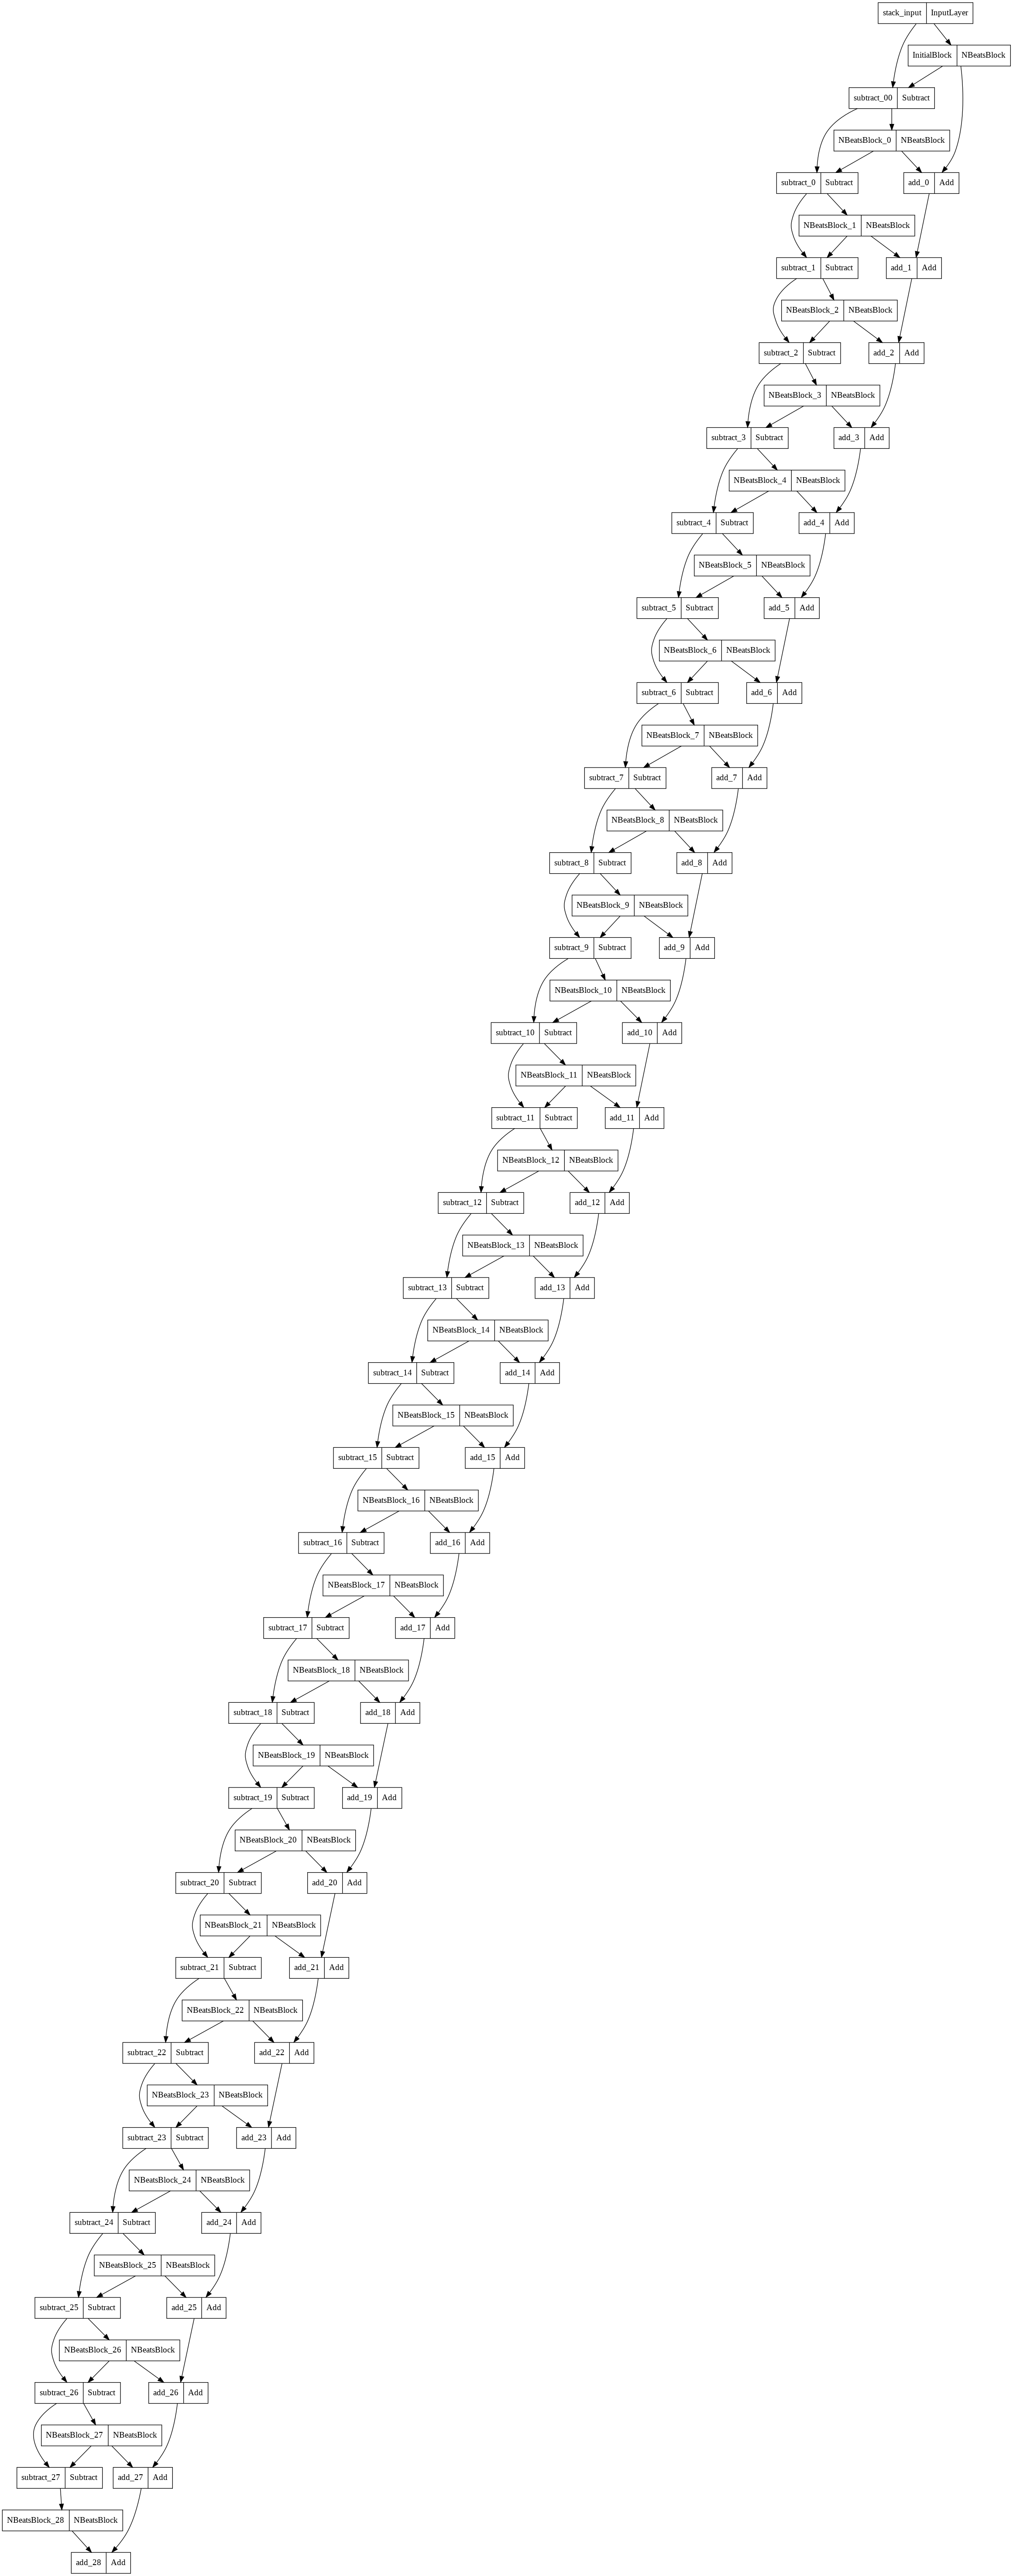

In [154]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

Now that is one good looking model! 

It even looks similar to the model shown in Figure 1 of the N-BEATS paper. 

![N-BEATS replica model compared with actual N-BEATS architecture](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-stack-model-vs-nbeats-architecture.png)
*Comparison of `model_7` (N-BEATS replica model make with Keras Functional API) versus actual N-BEATS architecture diagram.*

Looks like our Functional API usage did the trick! 

> 🔑 **Note:** Our N-BEATS model replicates the N-BEATS **generic architecture**, the training setups are largely the same, except for the N-BEATS paper used an ensemble of models to make predictions (multiple different loss functions and multiple different lookback windows), see Table 18 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) for more. An extension could be to setup this kind of training regime and see if it improves performance.

How about we try and save our version of the N-BEATS model?

In [155]:
# This will error out unless a "get_config()" method is implemented - this could be extra curriculum
model_7.save(model_7.name)

INFO:tensorflow:Assets written to: model_7_N-BEATS/assets


INFO:tensorflow:Assets written to: model_7_N-BEATS/assets


You'll notice a warning appears telling us to fully save our model correctly we need to implement a [`get_config()`](https://www.tensorflow.org/guide/keras/save_and_serialize#how_savedmodel_handles_custom_objects) method in our custom layer class.

> 📖 **Resource:** If you would like to save and load the N-BEATS model or any other custom or subclassed layer/model configuration, you should overwrite the `get_config()` and optionally `from_config()` methods. See the [TensorFlow Custom Objects documentation](https://www.tensorflow.org/guide/keras/save_and_serialize#custom_objects) for more.

## Model 8: Creating an ensemble (stacking different models together)

After all that effort, the N-BEATS algorithm's performance was underwhelming.

But again, this is part of the parcel of machine learning. Not everything will work.

That's when we refer back to the motto: experiment, experiment, experiment.

Our next experiment is creating an [**ensemble** of models](https://en.wikipedia.org/wiki/Ensemble_learning).

An **ensemble** involves training and combining multiple different models on the same problem. Ensemble models are often the types of models you'll see winning data science competitions on websites like Kaggle.

![high level overview of ensemble model: combining many different models may result in better results than one single model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-ensemble-model-example.png)
*Example of the power of ensembling. One Daniel model makes a decision with a smart level of 7 but when a Daniel model teams up with multiple different people, together (ensembled) they make a decision with a smart level of 10. The key here is combining the decision power of people with different backgrounds, if you combined multiple Daniel models, you'd end up with an average smart level of 7. Note: smart level is not an actual measurement of decision making, it is for demonstration purposes only.*

For example, in the N-BEATS paper, they trained an ensemble of models (180 in total, see [section 3.4](https://arxiv.org/pdf/1905.10437.pdf)) to achieve the results they did using a combination of:
  * Different loss functions (sMAPE, MASE and MAPE)
  * Different window sizes (2 x horizon, 3 x horizon, 4 x horizon...)

The benefit of ensembling models is you get the "decision of the crowd effect". Rather than relying on a single model's predictions, you can [take the average or median of many different models](https://en.wikipedia.org/wiki/Ensemble_forecasting).

The keyword being: different.

It wouldn't make sense to train the same model 10 times on the same data and then average the predictions.

Fortunately, due to their random initialization, even deep learning models with the same architecture can produce different results. 

What I mean by this is each time you create a deep learning model, it starts with random patterns (weights & biases) and then it adjusts these random patterns to better suit the dataset it's being trained on. 

However, the process it adjusts these patterns is often a form of guided randomness as well (the SGD optimizer stands for stochastic or random gradient descent).

To create our ensemble models we're going to be using a combination of: 
* Different loss functions (MAE, MSE, MAPE)
* Randomly initialized models 

Essentially, we'll be creating a suite of different models all attempting to model the same data.

And hopefully the combined predictive power of each model is better than a single model on its own.

Let's find out!

We'll start by creating a function to produce a list of different models trained with different loss functions. Each layer in the ensemble models will be initialized with a random normal [(Gaussian) distribution](https://en.wikipedia.org/wiki/Normal_distribution) using [He normal initialization](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), this'll help estimating the prediction intervals later on.

> 🔑 **Note:** In your machine leanring experiments, you may have already dealt with examples of ensemble models. Algorithms such as the [random forest model](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) are a form of ensemble, it uses a number of randomly created decision trees where each individual tree may perform poorly but when combined gives great results.


In [156]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting an ensemble of models (using different loss functions)

In [157]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal distribution for estimating prediction intervals later on #Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                           patience=200,
                                                           restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

Ensemble model creator function created!

Let's try it out by running `num_iter=5` runs for 1000 epochs. This will result in 15 total models (5 for each different loss function).

Of course, these numbers could be tweaked to create more models trained for longer. 

> 🔑 **Note:** With ensembles, you'll generally find more total models means better performance. However, this comes with the tradeoff of having to train more models (longer training time) and make predictions with more models (longer prediction time).



In [158]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 874: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 986: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 595: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 131: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 246: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 346: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 898: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 578: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 678: ReduceLROnPl

In [159]:
len(ensemble_models)

15

In [160]:
ensemble_models

### Making predictions with an ensemble model

In [161]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds=[]
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [162]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

CPU times: user 563 ms, sys: 18.9 ms, total: 582 ms
Wall time: 581 ms


Now we've got a set of ensemble predictions, we can evaluate them against the ground truth values.

However, since we've trained 15 models, there's going to be 15 sets of predictions. Rather than comparing every set of predictions to the ground truth, let's take the median (you could also take the mean too but [the median is usually more robust than the mean](https://www.johndcook.com/blog/2009/03/06/student-t-distribution-mean-median/)).

In [163]:
# Evaluate ensemble model(s) predictions (with MEAN)
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)
ensemble_results

{'mae': 586.27606,
 'mape': 2.687361,
 'mase': 1.0299248,
 'mse': 1192196.5,
 'rmse': 1091.4938}

In [164]:
# Evaluate ensemble model(s) predictions (with MEDIAN)
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 566.1467,
 'mape': 2.5743346,
 'mase': 0.994563,
 'mse': 1137113.0,
 'rmse': 1066.355}

In [165]:
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

Right now all of our model's (prior to the ensemble model) are predicting single points. 

Meaning, given a set of `WINDOW_SIZE=7` values, the model will predict `HORIZION=1`.

But what might be more helpful than a single value?

Perhaps a range of values?

For example, if a model is predicting the price of Bitcoin to be 50,000USD tomorrow, would it be helpful to know it's predicting the 50,000USD because it's predicting the price to be between 48,000 and 52,000USD? (note: "$" has been omitted from the previous sentence due to formatting issues)

Knowing the range of values a model is predicting may help you make better decisions for your forecasts.

You'd know that although the model is predicting 50,000USD (a **point prediction**, or single value in time), the value could actually be within the range 48,000USD to 52,000USD (of course, the value could also be *outside* of this range as well, but we'll get to that later).

These kind of prediction ranges are called **prediction intervals** or **uncertainty estimates**. And they're often as important as the forecast itself.

Why?

Because **point predictions** are almost always going to be wrong. So having a range of values can help with decision making.

> 📖 **Resource(s):** 
> * The steps we're about to take have been inspired by the Machine Learning Mastery blog post [*Prediction Intervals for Deep Learning Neural Networks*](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/). Check out the post for more options to measure uncertainty with neural networks.
> * For an example of uncertainty estimates being used in the wild, I'd also refer to Uber's [*Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber*](https://eng.uber.com/neural-networks-uncertainty-estimation/) blog post.

![example of Uber's prediction intervals for daily completed trips in San Francisco](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-intervals-from-ubers-uncertainty-measures.png)
*Example of how uncertainty estimates and predictions intervals can give an understanding of where point predictions (a single number) may not include all of useful information you'd like to know. For example, your model's point prediction for Uber trips on New Years Eve might be 100 (a made up number) but really, the prediction intervals are between 55 and 153 (both made up for the example). In this case, preparing 100 rides might end up being 53 short (it could even be more, like the point prediction, the prediction intervals are also estimates). The image comes from Uber's [blog post on uncertainty estimation in neural networks](https://eng.uber.com/neural-networks-uncertainty-estimation/).*

One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method: 
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by [1.96](https://en.wikipedia.org/wiki/1.96) (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)


In [166]:
tf.math.reduce_std(ensemble_preds)

<tf.Tensor: shape=(), dtype=float32, numpy=17505.285>

In [167]:
tf.math.reduce_std(ensemble_preds, axis=0)

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 47.391537,  40.873615,  37.496895,  53.739594,  48.705986,
        48.417503,  36.719746,  51.562424,  41.059387,  28.802277,
        40.000267,  42.86056 ,  37.05602 ,  42.39863 ,  51.04104 ,
        37.109535,  57.823944,  35.74225 ,  51.418575,  41.69903 ,
        54.53976 ,  44.31081 ,  67.437775,  59.681362,  48.683273,
        33.830814,  36.401527,  29.371618,  35.886166,  33.23004 ,
        46.241398,  44.721504,  33.27507 ,  26.572763,  25.537199,
        36.9601  ,  35.175842,  30.384233,  34.146496,  35.05299 ,
        55.607758,  60.426964,  48.654034,  68.50507 ,  82.12397 ,
        76.67652 ,  37.04003 ,  28.864391,  30.793314,  32.914833,
        29.859594,  33.811474,  40.58196 ,  37.676754,  28.86761 ,
        26.151258,  23.70923 ,  42.05345 ,  30.411528,  60.846855,
        51.42947 ,  42.675594,  63.935802,  55.4354  ,  63.21586 ,
        36.93289 ,  54.75468 ,  49.843395,  64.754585,  48.033207,
        66.975

In [168]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lpwer(preds): # 1. Take the predictions from a number of randomly initilized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  
  return lower, upper

In [169]:
# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lpwer(preds=ensemble_preds)
lower, upper

(<tf.Tensor: shape=(556,), dtype=float32, numpy=
 array([ 8674.439 ,  8686.787 ,  8977.993 ,  8595.97  ,  8645.618 ,
         8616.741 ,  8567.26  ,  8363.134 ,  8368.009 ,  8452.378 ,
         8102.595 ,  8014.1787,  7967.022 ,  7522.328 ,  7167.028 ,
         7224.8022,  6946.766 ,  7134.877 ,  7005.7607,  7447.3887,
         7258.85  ,  7654.5796,  7413.8193,  7259.125 ,  7210.354 ,
         7229.4272,  7118.8047,  7327.668 ,  7427.5493,  7459.7925,
         7443.9937,  7227.5835,  7148.452 ,  7111.0684,  7122.813 ,
         7151.408 ,  7000.8745,  7032.808 ,  6786.684 ,  6504.2446,
         7299.1074,  7031.0317,  7061.6724,  7126.87  ,  7087.389 ,
         7028.113 ,  7141.376 ,  7134.124 ,  7102.0024,  7137.503 ,
         7234.158 ,  7303.2104,  7150.269 ,  7083.5264,  7088.054 ,
         6878.7524,  7229.1465,  7238.3003,  7287.4805,  7589.295 ,
         7950.1445,  8037.299 ,  7714.1997,  7967.705 ,  7951.892 ,
         8080.526 ,  7980.412 ,  8646.92  ,  8748.539 ,  8659.804 ,

Now we've got the upper and lower bounds for the the 95% prediction interval, let's plot them against our ensemble model's predictions.

To do so, we can use our plotting function as well as the [`matplotlib.pyplot.fill_between()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html) method to shade in the space between the upper and lower bounds.

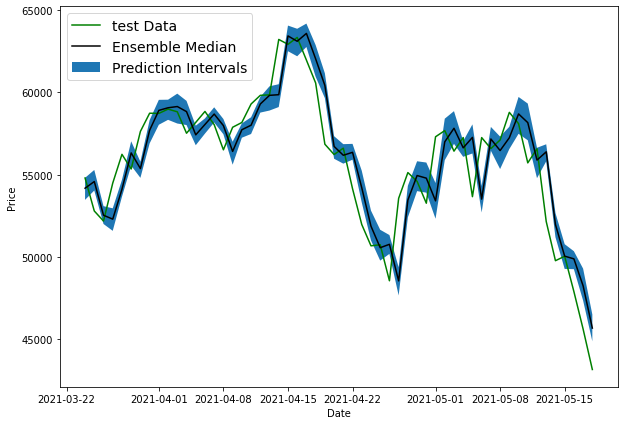

In [170]:
# Get the median/mean values of our ensemble_preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset= 500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("Price")
# To plot the upper and lower bounds, let's use fill_between:
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14)

We've just plotted:
* The test data (the ground truth Bitcoin prices)
* The median of the ensemble predictions 
* The 95% prediction intervals (assuming the data is Gaussian/normal, the model is saying that 95% of the time, predicted value should fall between this range)

What can you tell about the ensemble model from the plot above?

It looks like the ensemble predictions are lagging slightly behind the actual data.

And the prediction intervals are fairly low throughout.

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be **overfitting** the data, meaning it's basically replicating what a naïve model would do and just predicting the previous timestep value for the next value.

This would explain why previous attempts to beat the naïve forecast have been futile.

We can test this hypothesis of overfitting by creating a model to make predictions into the future and seeing what they look like.

> 🔑 **Note:** Our prediction intervals assume that the data we're using come from a Gaussian/normal distribution (also called a bell curve), however, open systems rarely follow the Gaussian. We'll see this later on with the turkey problem 🦃. For further reading on this topic, I'd recommend reading [*The Black Swan* by Nassim Nicholas Taleb](https://en.wikipedia.org/wiki/The_Black_Swan:_The_Impact_of_the_Highly_Improbable), especially Part 2 and Chapter 15.

## Aside: two types of uncertainty (coconut and subway)

Inheritly, you know you cannot predict the future.

That doesn't mean trying to isn't valuable.

For many things, future predictions are helpful. Such as knowing the bus you're trying to catch to the library leaves at 10:08am. The time 10:08am is a **point prediction**, if the bus left at a random time every day, how helpful would it be?

Just like saying the price of Bitcoin tomorrow will be 50,000USD is a point prediction.

However, as we've discussed knowing a **prediction interval** or **uncertainty estimate** can be as helpful or even more helpful than a point prediction itself.

Uncertainty estimates seek out to qualitatively and quantitatively answer the questions:
* What can my model know? (with perfect data, what's possible to learn?)
* What doesn't my model know? (what can a model never predict?)

There are two types of uncertainty in machine learning you should be aware of:

* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.
  * Let's say your train is scheduled to arrive at 10:08am but very rarely does it arrive at *exactly* 10:08am. You know it's usually a minute or two either side and perhaps up to 10-minutes late if traffic is bad. Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).
  * When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).

* **Epistemic uncertainty** - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.
  * The analogy for coconut uncertainty involves whether or not you'd get hit on the head by a coconut when going to a beach. 
    * If you were at a beach with coconuts trees, as you could imagine, this would be very hard to calculate. How often does a coconut fall of a tree? Where are you standing? 
    * But you could reduce this uncertainty to zero by going to a beach without coconuts (collect more data about your situation).
  * Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.

The lines between these are blurred (one type of uncertainty can change forms into the other) and they can be confusing at first but are important to keep in mind for any kind of time series prediction.

If you ignore the uncertanties, are you really going to get a reliable prediction?

Perhaps another example might help.

### Uncertainty in dating

Let's say you're going on a First Date Feedback Radio Show to help improve your dating skills.

Where you go on a blind first date with a girl (feel free to replace girl with your own preference) and the radio hosts record the date and then playback snippets of where you could've improved.

And now let's add a twist. 

Last week your friend went on the same show. They told you about the girl they met and how the conversation went.

Because you're now a machine learning engineer, you decide to build a machine learning model to help you with first date conversations.

What levels of uncertainty do we have here? 

From an **aleatory uncertainty** (data) point of view, no matter how many conversations of first dates you collect, the conversation you end up having will likely be different to the rest (the best conversations have no subject and appear random).

From an **epistemic uncertainty** (model) point of view, if the date is truly blind and both parties don't know who they're seeing until they meet in person, the epistemic uncertainty would be high. Because now you have no idea who the person you're going to meet is nor what you might talk about.

However, the level of epistemic uncertainty would be reduced if your friend told about the girl they went on a date with last week on the show and it turns out you're going on a date with the same girl.

But even though you know a little bit about the girl, your **aleatory uncertainty** (or subway uncertainty) is still high because you're not sure where the conversation will go.

### Learning more on uncertainty

The field of quantifying uncertainty estimation in machine learning is a growing area of research.

If you'd like to learn more I'd recommend the following.

> 📖 **Resources:** Places to learn more about uncertainty in machine learning/forecasting:
* 🎥 [MIT 6.S191: Evidential Deep Learning and Uncertainty](https://youtu.be/toTcf7tZK8c) 
* [Uncertainty quantification on Wikipedia](https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty)
* [*Why you should care about the Nate Silver vs. Nassim Taleb Twitter war*](https://towardsdatascience.com/why-you-should-care-about-the-nate-silver-vs-nassim-taleb-twitter-war-a581dce1f5fc) by Isaac Faber - a great insight into the role of uncertainty in the example of election prediction. 
* [*3 facts about time series forecasting that surprise experienced machine learning practitioners*](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) by Skander Hannachi - fantastic outline of some of the main mistakes people make when building forecasting models, especially forgetting about uncertainty estimates.
* [*Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber*](https://eng.uber.com/neural-networks-uncertainty-estimation/) - a discussion on techniques Uber used to engineer uncertainty estimates into their time sereis neural networks.


## Model 9: Train a model on the full historical data to make predictions into future

What would a forecasting model be worth if we didn't use it to predict into the future?

It's time we created a model which is able to make future predictions on the price of Bitcoin.

To make predictions into the future, we'll train a model on the full dataset and then get to make predictions to some future horizon.

Why use the full dataset?

Previously, we split our data into training and test sets to evaluate how our model did on pseudo-future data (the test set).

But since the goal of a forecasting model is to predict values into the actual-future, we won't be using a test set.

> 🔑 **Note:** Forecasting models need to be retrained every time a forecast is made. Why? Because if Bitcoin prices are updated daily and you predict the price for tomorrow. Your model is only really valid for one day. When a new price comes out (e.g. the next day), you'll have to retrain your model to incorporate that new price to predict the next forecast.

Let's get some data ready.

In [171]:
HORIZON = 1
WINDOW_SIZE = 7

In [172]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [173]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy() # only want prices, our future model can be a univariate model
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [174]:
X_all[:5], y_all[:5]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866]]),
 array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ]))

Windows and labels ready! Let's turn them into performance optimized TensorFlow Datasets by:
1. Turning `X_all` and `y_all` into tensor Datasets using [`tf.data.Dataset.from_tensor_slices()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
2. Combining the features and labels into a Dataset tuple using [`tf.data.Dataset.zip()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
3. Batch and prefetch the data using [`tf.data.Dataset.batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`tf.data.Dataset.prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) respectively

In [175]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

And now let's create a model similar to `model_1` except with an extra layer, we'll also fit it to the entire dataset for 100 epochs (feel free to play around with the number of epochs or callbacks here, you've got the skills to now).

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_9 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)                         
], name="model_9_dense") # give the model a name so we can save it


# 2. Compile a model
model_9.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam()) # we don't necessarily need this when the loss function is already MAE

# 3. Fit the model
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) 

### Make predictions on the future

As you've seen so far, our machine learning models have performed quite poorly at predicting the price of Bitcoin (time series forecasting in open systems is typically a game of luck), often worse than the naive forecast.

That doesn't mean we can't use our models to *try* and predict into the future right?

To do so, let's start by defining a variable `INTO_FUTURE` which decides how many timesteps we'd like to predict into the future.

In [ ]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

![flowchart representation prediction loop to make forecasts and then append forecasts to data and make more forecasts continuously until forecast horizon is exhausted](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-loop-for-forecasts.png)
*Example flow chart representing the loop we're about to create for making forecasts. Not pictured: retraining a forecasting model every time a forecast is made & new data is acquired. For example, if you're predicting the price of Bitcoin daily, you'd want to retrain your model every day, since each day you're going to have a new data point to work with.*

Alright, let's create a function which returns `INTO_FUTURE` forecasted values using a trained model.

To do so, we'll build the following steps:
1. Function which takes as input: 
  * a list of values (the Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction 
  * Eventually future predictions will be made using the model's own previous predictions as input